In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -36]) # Column containing response actual values (temperature) at time t

    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 2:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + 12*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]


Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 190)
(2, 190)


[I 2025-06-04 20:19:18,842] A new study created in memory with name: no-name-562ca779-906a-4fa4-8753-cc66394e8b26
[I 2025-06-04 20:20:31,331] Trial 0 finished with value: 0.11482663005590439 and parameters: {'lr': 0.0010462811708209353, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4613902986358399}. Best is trial 0 with value: 0.11482663005590439.


Cross Validation Accuracies:
[0.18084633350372314, 0.1067575141787529, 0.09851565212011337, 0.11355292052030563, 0.07446072995662689]
Mean Cross Validation Accuracy:
0.11482663005590439
Standard Deviation of Cross Validation Accuracy:
0.035554994311361145


[I 2025-06-04 20:21:50,621] Trial 1 finished with value: 0.09138915538787842 and parameters: {'lr': 0.0016752058646333093, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3845464249434408}. Best is trial 1 with value: 0.09138915538787842.


Cross Validation Accuracies:
[0.11542405188083649, 0.09367199242115021, 0.07481645047664642, 0.10439528524875641, 0.06863799691200256]
Mean Cross Validation Accuracy:
0.09138915538787842
Standard Deviation of Cross Validation Accuracy:
0.017574508632533077


[I 2025-06-04 20:22:46,829] Trial 2 finished with value: 0.11517435908317566 and parameters: {'lr': 0.0011444331358042036, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.24082842216943107}. Best is trial 1 with value: 0.09138915538787842.


Cross Validation Accuracies:
[0.14889872074127197, 0.09513804316520691, 0.09516801685094833, 0.1504819095134735, 0.08618510514497757]
Mean Cross Validation Accuracy:
0.11517435908317566
Standard Deviation of Cross Validation Accuracy:
0.02837618795964351


[I 2025-06-04 20:24:40,419] Trial 3 finished with value: 19.02795066833496 and parameters: {'lr': 0.18236710614998514, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.37604226038734934}. Best is trial 1 with value: 0.09138915538787842.


Cross Validation Accuracies:
[20.110912322998047, 18.205955505371094, 21.067167282104492, 16.017559051513672, 19.7381591796875]
Mean Cross Validation Accuracy:
19.02795066833496
Standard Deviation of Cross Validation Accuracy:
1.7648648791058064


[I 2025-06-04 20:26:07,762] Trial 4 finished with value: 0.16350207030773162 and parameters: {'lr': 0.0018012753181300368, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.2310592645988928}. Best is trial 1 with value: 0.09138915538787842.


Cross Validation Accuracies:
[0.1481618583202362, 0.20821073651313782, 0.14378388226032257, 0.17950958013534546, 0.1378442943096161]
Mean Cross Validation Accuracy:
0.16350207030773162
Standard Deviation of Cross Validation Accuracy:
0.02659908162930194


[I 2025-06-04 20:27:07,257] Trial 5 finished with value: 0.09049471914768219 and parameters: {'lr': 0.0027243722987872164, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2912375416151961}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11294855922460556, 0.0823507159948349, 0.08149102330207825, 0.10818266123533249, 0.06750063598155975]
Mean Cross Validation Accuracy:
0.09049471914768219
Standard Deviation of Cross Validation Accuracy:
0.017280957244206172


[I 2025-06-04 20:28:16,638] Trial 6 finished with value: 0.16899393498897552 and parameters: {'lr': 0.0701839623877717, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.4943403847573362}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.21667438745498657, 0.18725545704364777, 0.12524402141571045, 0.15344633162021637, 0.16234947741031647]
Mean Cross Validation Accuracy:
0.16899393498897552
Standard Deviation of Cross Validation Accuracy:
0.031005936398734467


[I 2025-06-04 20:30:43,595] Trial 7 finished with value: 0.9244011759757995 and parameters: {'lr': 0.032917739481936034, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15924671146380276}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.91639244556427, 0.9293385148048401, 0.9747983813285828, 0.867315948009491, 0.934160590171814]
Mean Cross Validation Accuracy:
0.9244011759757995
Standard Deviation of Cross Validation Accuracy:
0.034590070258103546


[I 2025-06-04 20:32:19,012] Trial 8 finished with value: 0.10154557675123214 and parameters: {'lr': 0.001004503415929118, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4212313156594475}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.16699983179569244, 0.09611789882183075, 0.0680055022239685, 0.10085933655500412, 0.07574531435966492]
Mean Cross Validation Accuracy:
0.10154557675123214
Standard Deviation of Cross Validation Accuracy:
0.034942181544676355


[I 2025-06-04 20:34:08,826] Trial 9 finished with value: 115.36971540153027 and parameters: {'lr': 0.3610700806581219, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.29687991131107205}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.25838711857795715, 0.1994762420654297, 0.20057810842990875, 575.868408203125, 0.32172733545303345]
Mean Cross Validation Accuracy:
115.36971540153027
Standard Deviation of Cross Validation Accuracy:
230.2493507925617


[I 2025-06-04 20:35:07,695] Trial 10 finished with value: 0.0906759649515152 and parameters: {'lr': 0.00845564514659213, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13099534719841632}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11421477794647217, 0.0901370570063591, 0.07481592893600464, 0.10530617088079453, 0.06890588998794556]
Mean Cross Validation Accuracy:
0.0906759649515152
Standard Deviation of Cross Validation Accuracy:
0.017285172668219207


[I 2025-06-04 20:36:06,092] Trial 11 finished with value: 0.09058334678411484 and parameters: {'lr': 0.006974094880621282, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10078035840995339}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11413122713565826, 0.08997903764247894, 0.07485217601060867, 0.10497827082872391, 0.0689760223031044]
Mean Cross Validation Accuracy:
0.09058334678411484
Standard Deviation of Cross Validation Accuracy:
0.01718387559296343


[I 2025-06-04 20:37:05,318] Trial 12 finished with value: 0.09055291712284089 and parameters: {'lr': 0.007034288807820131, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18761278710977664}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11450541764497757, 0.08987994492053986, 0.07470406591892242, 0.10521737486124039, 0.06845778226852417]
Mean Cross Validation Accuracy:
0.09055291712284089
Standard Deviation of Cross Validation Accuracy:
0.017484865240108213


[I 2025-06-04 20:38:05,673] Trial 13 finished with value: 0.09065482616424561 and parameters: {'lr': 0.0068894454042155604, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2100045762507721}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11444901674985886, 0.0899161770939827, 0.07530016452074051, 0.10495100170373917, 0.0686577707529068]
Mean Cross Validation Accuracy:
0.09065482616424561
Standard Deviation of Cross Validation Accuracy:
0.017266880575746952


[I 2025-06-04 20:38:59,964] Trial 14 finished with value: 0.090768101811409 and parameters: {'lr': 0.004137117373617651, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3012357343251271}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11444257944822311, 0.08970393985509872, 0.07535755634307861, 0.10534488409757614, 0.06899154931306839]
Mean Cross Validation Accuracy:
0.090768101811409
Standard Deviation of Cross Validation Accuracy:
0.017238323956858734


[I 2025-06-04 20:39:53,299] Trial 15 finished with value: 0.09089085757732392 and parameters: {'lr': 0.018356579800846234, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.30494093492869734}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1134205311536789, 0.0907762423157692, 0.07631535083055496, 0.10489199310541153, 0.06905017048120499]
Mean Cross Validation Accuracy:
0.09089085757732392
Standard Deviation of Cross Validation Accuracy:
0.016691867085181628


[I 2025-06-04 20:40:53,983] Trial 16 finished with value: 0.09052975475788116 and parameters: {'lr': 0.003293337220854691, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.18408772618733582}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11414065957069397, 0.08975476771593094, 0.0750148668885231, 0.10510539263486862, 0.06863308697938919]
Mean Cross Validation Accuracy:
0.09052975475788116
Standard Deviation of Cross Validation Accuracy:
0.01726673365704337


[I 2025-06-04 20:42:00,491] Trial 17 finished with value: 0.09437453001737595 and parameters: {'lr': 0.0034458151156105655, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.261743395104897}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.12653768062591553, 0.09932099282741547, 0.07095993310213089, 0.10746210813522339, 0.06759193539619446]
Mean Cross Validation Accuracy:
0.09437453001737595
Standard Deviation of Cross Validation Accuracy:
0.022341759893685215


[I 2025-06-04 20:43:07,881] Trial 18 finished with value: 0.09335739463567734 and parameters: {'lr': 0.02054739015776662, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.3475115466885418}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11739447712898254, 0.0908898115158081, 0.07075563818216324, 0.11026248335838318, 0.07748456299304962]
Mean Cross Validation Accuracy:
0.09335739463567734
Standard Deviation of Cross Validation Accuracy:
0.018068970668553033


[I 2025-06-04 20:44:10,656] Trial 19 finished with value: 0.32677978873252866 and parameters: {'lr': 0.0029439925071787316, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.17669066608647432}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.2780362367630005, 0.378471702337265, 0.3468554615974426, 0.3224700391292572, 0.3080655038356781]
Mean Cross Validation Accuracy:
0.32677978873252866
Standard Deviation of Cross Validation Accuracy:
0.03411691320312566


[I 2025-06-04 20:45:13,444] Trial 20 finished with value: 0.11849746704101563 and parameters: {'lr': 0.053838161304869285, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.2700913719160924}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1153460443019867, 0.14244917035102844, 0.11030074208974838, 0.12242785841226578, 0.10196352005004883]
Mean Cross Validation Accuracy:
0.11849746704101563
Standard Deviation of Cross Validation Accuracy:
0.013708546502740341


[I 2025-06-04 20:46:08,376] Trial 21 finished with value: 0.09065844565629959 and parameters: {'lr': 0.012178977892874556, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18695474389876277}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11402525007724762, 0.09002309292554855, 0.0749603882431984, 0.10537292808294296, 0.06891056895256042]
Mean Cross Validation Accuracy:
0.09065844565629959
Standard Deviation of Cross Validation Accuracy:
0.017218166933151556


[I 2025-06-04 20:47:02,853] Trial 22 finished with value: 0.09060006737709045 and parameters: {'lr': 0.004160134551384418, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15020502308391132}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11409487575292587, 0.08997564017772675, 0.07479333877563477, 0.10534046590328217, 0.06879601627588272]
Mean Cross Validation Accuracy:
0.09060006737709045
Standard Deviation of Cross Validation Accuracy:
0.017291296031007285


[I 2025-06-04 20:48:06,350] Trial 23 finished with value: 0.0935567632317543 and parameters: {'lr': 0.9477744397697343, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.21396224706390266}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11568742245435715, 0.09243017435073853, 0.07563264667987823, 0.11486950516700745, 0.06916406750679016]
Mean Cross Validation Accuracy:
0.0935567632317543
Standard Deviation of Cross Validation Accuracy:
0.019295314497713812


[I 2025-06-04 20:49:05,656] Trial 24 finished with value: 0.14214089661836624 and parameters: {'lr': 0.00253301353696239, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1120868755811848}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.15075959265232086, 0.09270861744880676, 0.13947544991970062, 0.10491561144590378, 0.22284521162509918]
Mean Cross Validation Accuracy:
0.14214089661836624
Standard Deviation of Cross Validation Accuracy:
0.045659270840002535


[I 2025-06-04 20:50:18,452] Trial 25 finished with value: 0.09481630623340606 and parameters: {'lr': 0.0060773614315966775, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1849481750730795}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.12298890203237534, 0.09234584122896194, 0.07687927782535553, 0.10448770225048065, 0.07737980782985687]
Mean Cross Validation Accuracy:
0.09481630623340606
Standard Deviation of Cross Validation Accuracy:
0.017430448743492265


[I 2025-06-04 20:51:17,147] Trial 26 finished with value: 0.09094591289758683 and parameters: {'lr': 0.012781480309648832, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3337789963686824}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11439865082502365, 0.09063947200775146, 0.07453279942274094, 0.10571442544460297, 0.0694442167878151]
Mean Cross Validation Accuracy:
0.09094591289758683
Standard Deviation of Cross Validation Accuracy:
0.017320202162206484


[I 2025-06-04 20:52:23,847] Trial 27 finished with value: 0.16142771244049073 and parameters: {'lr': 0.002136398907898572, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2500998246631624}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11621643602848053, 0.24766647815704346, 0.1467941254377365, 0.10105821490287781, 0.1954033076763153]
Mean Cross Validation Accuracy:
0.16142771244049073
Standard Deviation of Cross Validation Accuracy:
0.05384077154026914


[I 2025-06-04 20:54:14,436] Trial 28 finished with value: 0.29542393088340757 and parameters: {'lr': 0.004357090675289263, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2181787365369411}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.2913043797016144, 0.307065486907959, 0.29346850514411926, 0.3084915578365326, 0.27678972482681274]
Mean Cross Validation Accuracy:
0.29542393088340757
Standard Deviation of Cross Validation Accuracy:
0.011613067880450275


[I 2025-06-04 20:55:25,352] Trial 29 finished with value: 0.10887841731309891 and parameters: {'lr': 0.013651575017630523, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.141618986648831}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1176077350974083, 0.11556791514158249, 0.10249060392379761, 0.13248279690742493, 0.07624303549528122]
Mean Cross Validation Accuracy:
0.10887841731309891
Standard Deviation of Cross Validation Accuracy:
0.018889094274215815


[I 2025-06-04 20:56:41,580] Trial 30 finished with value: 0.11901537626981736 and parameters: {'lr': 0.001444253411960304, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.2808473120847088}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1368304193019867, 0.11957847326993942, 0.13988995552062988, 0.11528044193983078, 0.08349759131669998]
Mean Cross Validation Accuracy:
0.11901537626981736
Standard Deviation of Cross Validation Accuracy:
0.020143999989045116


[I 2025-06-04 20:57:42,781] Trial 31 finished with value: 0.09064573794603348 and parameters: {'lr': 0.007791885686014618, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11994689099214509}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1140495166182518, 0.0902644470334053, 0.0746697261929512, 0.10556261241436005, 0.06868238747119904]
Mean Cross Validation Accuracy:
0.09064573794603348
Standard Deviation of Cross Validation Accuracy:
0.017366733132152864


[I 2025-06-04 20:58:45,769] Trial 32 finished with value: 0.09051685780286789 and parameters: {'lr': 0.005678403318928586, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11231784981728177}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11400330811738968, 0.08967306464910507, 0.07500983029603958, 0.10516603291034698, 0.06873205304145813]
Mean Cross Validation Accuracy:
0.09051685780286789
Standard Deviation of Cross Validation Accuracy:
0.01721609297827294


[I 2025-06-04 20:59:51,297] Trial 33 finished with value: 0.11124971956014633 and parameters: {'lr': 0.0022963198357939542, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1649087444074648}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.14691144227981567, 0.13658106327056885, 0.07519150525331497, 0.10536342859268188, 0.09220115840435028]
Mean Cross Validation Accuracy:
0.11124971956014633
Standard Deviation of Cross Validation Accuracy:
0.02687424925078755


[I 2025-06-04 21:01:10,151] Trial 34 finished with value: 0.09055189043283463 and parameters: {'lr': 0.00470575614693932, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19755822058827374}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11415420472621918, 0.09018600732088089, 0.07442612200975418, 0.10518154501914978, 0.0688115730881691]
Mean Cross Validation Accuracy:
0.09055189043283463
Standard Deviation of Cross Validation Accuracy:
0.017343077634905477


[I 2025-06-04 21:02:47,596] Trial 35 finished with value: 0.13289376795291902 and parameters: {'lr': 0.001661813686804534, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.4163243459079391}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.13924261927604675, 0.09777335077524185, 0.1637762486934662, 0.15919001400470734, 0.1044866070151329]
Mean Cross Validation Accuracy:
0.13289376795291902
Standard Deviation of Cross Validation Accuracy:
0.0272981266079158


[I 2025-06-04 21:04:09,697] Trial 36 finished with value: 0.09063174724578857 and parameters: {'lr': 0.00469599120760953, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13804428266337612}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.1142459511756897, 0.0897241160273552, 0.07478460669517517, 0.10534321516752243, 0.06906084716320038]
Mean Cross Validation Accuracy:
0.09063174724578857
Standard Deviation of Cross Validation Accuracy:
0.017270305753447075


[I 2025-06-04 21:05:15,640] Trial 37 finished with value: 0.1388636887073517 and parameters: {'lr': 0.001373097001760684, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24293645457420848}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.13281327486038208, 0.14917263388633728, 0.1143631637096405, 0.16513609886169434, 0.13283327221870422]
Mean Cross Validation Accuracy:
0.1388636887073517
Standard Deviation of Cross Validation Accuracy:
0.017145046176263046


[I 2025-06-04 21:06:25,108] Trial 38 finished with value: 0.20085490643978118 and parameters: {'lr': 0.03368810836770799, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3310311195167001}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.18630360066890717, 0.16835430264472961, 0.22850346565246582, 0.14827236533164978, 0.27284079790115356]
Mean Cross Validation Accuracy:
0.20085490643978118
Standard Deviation of Cross Validation Accuracy:
0.044675193949426865


[I 2025-06-04 21:08:38,173] Trial 39 finished with value: 0.12333502769470214 and parameters: {'lr': 0.002835000702471803, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.210919460061499}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11018455773591995, 0.13079388439655304, 0.13312390446662903, 0.131906196475029, 0.11066659539937973]
Mean Cross Validation Accuracy:
0.12333502769470214
Standard Deviation of Cross Validation Accuracy:
0.010567361288169968


[I 2025-06-04 21:09:43,337] Trial 40 finished with value: 0.16639876663684844 and parameters: {'lr': 0.15445066748952013, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3802694997335541}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.18292993307113647, 0.17619283497333527, 0.1377500742673874, 0.1697324961423874, 0.16538849472999573]
Mean Cross Validation Accuracy:
0.16639876663684844
Standard Deviation of Cross Validation Accuracy:
0.015505387544204097


[I 2025-06-04 21:10:47,145] Trial 41 finished with value: 0.09053884446620941 and parameters: {'lr': 0.005563906441707295, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.18614394572709303}. Best is trial 5 with value: 0.09049471914768219.


Cross Validation Accuracies:
[0.11460188031196594, 0.08963753283023834, 0.07504510879516602, 0.10505019128322601, 0.06835950911045074]
Mean Cross Validation Accuracy:
0.09053884446620941
Standard Deviation of Cross Validation Accuracy:
0.017449355318122257


[I 2025-06-04 21:11:51,292] Trial 42 finished with value: 0.09034176021814347 and parameters: {'lr': 0.009376135927050826, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17160486864030267}. Best is trial 42 with value: 0.09034176021814347.


Cross Validation Accuracies:
[0.11368945240974426, 0.08994325995445251, 0.07417432218790054, 0.10533606261014938, 0.06856570392847061]
Mean Cross Validation Accuracy:
0.09034176021814347
Standard Deviation of Cross Validation Accuracy:
0.017353301226853402


[I 2025-06-04 21:12:44,762] Trial 43 finished with value: 0.09064469039440155 and parameters: {'lr': 0.010930177546698417, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15495807136586068}. Best is trial 42 with value: 0.09034176021814347.


Cross Validation Accuracies:
[0.11415761709213257, 0.08976545929908752, 0.07502558827400208, 0.10514400899410248, 0.0691307783126831]
Mean Cross Validation Accuracy:
0.09064469039440155
Standard Deviation of Cross Validation Accuracy:
0.017150310627944036


[I 2025-06-04 21:13:39,023] Trial 44 finished with value: 0.09016338735818863 and parameters: {'lr': 0.021959211767046075, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16810026842760226}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11317278444766998, 0.08946311473846436, 0.07415103167295456, 0.10570037364959717, 0.06832963228225708]
Mean Cross Validation Accuracy:
0.09016338735818863
Standard Deviation of Cross Validation Accuracy:
0.01734606050081113


[I 2025-06-04 21:15:04,441] Trial 45 finished with value: 0.0903822049498558 and parameters: {'lr': 0.0233817459111804, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12654579244889536}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11410270631313324, 0.08946763724088669, 0.07468166947364807, 0.10524162650108337, 0.06841738522052765]
Mean Cross Validation Accuracy:
0.0903822049498558
Standard Deviation of Cross Validation Accuracy:
0.017396902872857358


[I 2025-06-04 21:16:58,879] Trial 46 finished with value: 0.11183049231767654 and parameters: {'lr': 0.020599611199095858, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.10467359779728995}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.12195645272731781, 0.1135898232460022, 0.10945595055818558, 0.1223318949341774, 0.09181834012269974]
Mean Cross Validation Accuracy:
0.11183049231767654
Standard Deviation of Cross Validation Accuracy:
0.011153783756997604


[I 2025-06-04 21:18:45,153] Trial 47 finished with value: 0.11433520466089249 and parameters: {'lr': 0.05836526334889622, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12247429958392166}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.12981384992599487, 0.10394042730331421, 0.09050430357456207, 0.14810822904109955, 0.09930921345949173]
Mean Cross Validation Accuracy:
0.11433520466089249
Standard Deviation of Cross Validation Accuracy:
0.021363282938320113


[I 2025-06-04 21:20:37,495] Trial 48 finished with value: 0.6537213802337647 and parameters: {'lr': 0.030757323519371185, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.49429370209072737}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.7691289782524109, 0.5826026797294617, 0.5708266496658325, 0.5965745449066162, 0.749474048614502]
Mean Cross Validation Accuracy:
0.6537213802337647
Standard Deviation of Cross Validation Accuracy:
0.08681319472030034


[I 2025-06-04 21:22:01,485] Trial 49 finished with value: 0.15906976908445358 and parameters: {'lr': 0.08498525550209308, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16150255171919786}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.20740577578544617, 0.12169186025857925, 0.14240166544914246, 0.18254244327545166, 0.14130710065364838]
Mean Cross Validation Accuracy:
0.15906976908445358
Standard Deviation of Cross Validation Accuracy:
0.031233898617530016


[I 2025-06-04 21:23:12,061] Trial 50 finished with value: 0.1332777827978134 and parameters: {'lr': 0.025897696117410024, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.13448263861692483}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.17211534082889557, 0.1123085469007492, 0.15259258449077606, 0.1190151795744896, 0.11035726219415665]
Mean Cross Validation Accuracy:
0.1332777827978134
Standard Deviation of Cross Validation Accuracy:
0.02469776689424165


[I 2025-06-04 21:24:57,429] Trial 51 finished with value: 0.09048675745725632 and parameters: {'lr': 0.009683723635361975, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1725016553990139}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11358983814716339, 0.08988092839717865, 0.07505018264055252, 0.10481944680213928, 0.06909339129924774]
Mean Cross Validation Accuracy:
0.09048675745725632
Standard Deviation of Cross Validation Accuracy:
0.016944080427769657


[I 2025-06-04 21:26:22,829] Trial 52 finished with value: 0.09063587337732315 and parameters: {'lr': 0.008885626997441743, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.23262725254162658}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11408638209104538, 0.09008990973234177, 0.07463500648736954, 0.10553282499313354, 0.06883524358272552]
Mean Cross Validation Accuracy:
0.09063587337732315
Standard Deviation of Cross Validation Accuracy:
0.01734035065013918


[I 2025-06-04 21:27:44,760] Trial 53 finished with value: 0.0940044328570366 and parameters: {'lr': 0.040857013222355146, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16532478779254822}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11323942244052887, 0.08946699649095535, 0.07596222311258316, 0.10284280776977539, 0.08851071447134018]
Mean Cross Validation Accuracy:
0.0940044328570366
Standard Deviation of Cross Validation Accuracy:
0.012840500755933256


[I 2025-06-04 21:29:09,554] Trial 54 finished with value: 0.09078403115272522 and parameters: {'lr': 0.0162512054901091, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10131128559155048}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11454740166664124, 0.09004078805446625, 0.07530254870653152, 0.1050596535205841, 0.06896976381540298]
Mean Cross Validation Accuracy:
0.09078403115272522
Standard Deviation of Cross Validation Accuracy:
0.017231263103269258


[I 2025-06-04 21:30:36,290] Trial 55 finished with value: 0.09071439057588578 and parameters: {'lr': 0.00947997277099747, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12640052147435937}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11451750993728638, 0.09002276510000229, 0.07477062195539474, 0.10519729554653168, 0.06906376034021378]
Mean Cross Validation Accuracy:
0.09071439057588578
Standard Deviation of Cross Validation Accuracy:
0.01731920853241443


[I 2025-06-04 21:31:34,263] Trial 56 finished with value: 0.09062604159116745 and parameters: {'lr': 0.02424895647422906, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.14986597389720285}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11466744542121887, 0.09022940695285797, 0.07514877617359161, 0.10499918460845947, 0.06808539479970932]
Mean Cross Validation Accuracy:
0.09062604159116745
Standard Deviation of Cross Validation Accuracy:
0.017506342621660353


[I 2025-06-04 21:32:53,238] Trial 57 finished with value: 0.09416840523481369 and parameters: {'lr': 0.016765223995574754, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.4058110450234875}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11525086313486099, 0.09328559041023254, 0.07753990590572357, 0.11269042640924454, 0.0720752403140068]
Mean Cross Validation Accuracy:
0.09416840523481369
Standard Deviation of Cross Validation Accuracy:
0.017623447946774513


[I 2025-06-04 21:33:45,532] Trial 58 finished with value: 0.09729640185832977 and parameters: {'lr': 0.04428162172042505, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1758723081086908}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11270222812891006, 0.09090907126665115, 0.08018121868371964, 0.11039932817220688, 0.09229016304016113]
Mean Cross Validation Accuracy:
0.09729640185832977
Standard Deviation of Cross Validation Accuracy:
0.012392062583432872


[I 2025-06-04 21:34:39,235] Trial 59 finished with value: 0.2445491820573807 and parameters: {'lr': 0.0862507003659937, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19988482623680312}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.18530753254890442, 0.25150540471076965, 0.17486120760440826, 0.2733074426651001, 0.33776432275772095]
Mean Cross Validation Accuracy:
0.2445491820573807
Standard Deviation of Cross Validation Accuracy:
0.05988401433172721


[I 2025-06-04 21:36:04,883] Trial 60 finished with value: 0.09103571027517318 and parameters: {'lr': 0.009999242185775014, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.44864028055095145}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11496373265981674, 0.09042390435934067, 0.07589192688465118, 0.1050669252872467, 0.06883206218481064]
Mean Cross Validation Accuracy:
0.09103571027517318
Standard Deviation of Cross Validation Accuracy:
0.017275043967141725


[I 2025-06-04 21:37:01,650] Trial 61 finished with value: 0.09065562784671784 and parameters: {'lr': 0.003123812817691269, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.13992913609599653}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11471778154373169, 0.08960949629545212, 0.07482153922319412, 0.10531645268201828, 0.06881286948919296]
Mean Cross Validation Accuracy:
0.09065562784671784
Standard Deviation of Cross Validation Accuracy:
0.017451910335636377


[I 2025-06-04 21:37:54,886] Trial 62 finished with value: 0.09067706763744354 and parameters: {'lr': 0.005748333180671762, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.17650044393599093}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11406553536653519, 0.09014822542667389, 0.07486704736948013, 0.10539300739765167, 0.06891152262687683]
Mean Cross Validation Accuracy:
0.09067706763744354
Standard Deviation of Cross Validation Accuracy:
0.017248505270342395


[I 2025-06-04 21:38:46,147] Trial 63 finished with value: 0.0904862180352211 and parameters: {'lr': 0.003642326440048041, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1182478823306219}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11385468393564224, 0.09008222818374634, 0.0747876763343811, 0.10504209250211716, 0.06866440922021866]
Mean Cross Validation Accuracy:
0.0904862180352211
Standard Deviation of Cross Validation Accuracy:
0.017209052497606063


[I 2025-06-04 21:39:41,876] Trial 64 finished with value: 0.09053122699260711 and parameters: {'lr': 0.013964202295837233, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.12282611338081065}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11395098268985748, 0.09006694704294205, 0.07476183772087097, 0.10471638292074203, 0.06915998458862305]
Mean Cross Validation Accuracy:
0.09053122699260711
Standard Deviation of Cross Validation Accuracy:
0.01706061429954647


[I 2025-06-04 21:40:39,985] Trial 65 finished with value: 0.09062410593032837 and parameters: {'lr': 0.007331480885116964, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11422239624061678}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11417149007320404, 0.08980879187583923, 0.07503195106983185, 0.1052369698882103, 0.06887132674455643]
Mean Cross Validation Accuracy:
0.09062410593032837
Standard Deviation of Cross Validation Accuracy:
0.017233563331649222


[I 2025-06-04 21:41:37,974] Trial 66 finished with value: 0.09056941419839859 and parameters: {'lr': 0.003705049267911652, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1488798768631475}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11400355398654938, 0.09006376564502716, 0.07488910853862762, 0.10511374473571777, 0.06877689808607101]
Mean Cross Validation Accuracy:
0.09056941419839859
Standard Deviation of Cross Validation Accuracy:
0.017214748809894476


[I 2025-06-04 21:42:45,269] Trial 67 finished with value: 0.1474095582962036 and parameters: {'lr': 0.0021163760504522345, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.10006771242092286}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.18769533932209015, 0.13613857328891754, 0.11748957633972168, 0.15432441234588623, 0.14139989018440247]
Mean Cross Validation Accuracy:
0.1474095582962036
Standard Deviation of Cross Validation Accuracy:
0.023362858958264347


[I 2025-06-04 21:43:49,722] Trial 68 finished with value: 0.15966421067714692 and parameters: {'lr': 0.005524600470948771, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.19677274934232097}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.1550443321466446, 0.08026646077632904, 0.21453414857387543, 0.23231133818626404, 0.11616477370262146]
Mean Cross Validation Accuracy:
0.15966421067714692
Standard Deviation of Cross Validation Accuracy:
0.057455830346740094


[I 2025-06-04 21:45:02,526] Trial 69 finished with value: 0.10576702356338501 and parameters: {'lr': 0.021587915345638458, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.3599616958838267}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.12392224371433258, 0.08622916787862778, 0.11919663846492767, 0.12519137561321259, 0.07429569214582443]
Mean Cross Validation Accuracy:
0.10576702356338501
Standard Deviation of Cross Validation Accuracy:
0.021257678770933982


[I 2025-06-04 21:46:06,189] Trial 70 finished with value: 0.09047524183988571 and parameters: {'lr': 0.007137083260587945, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22744866311310796}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11409346014261246, 0.08978581428527832, 0.07452009618282318, 0.10529913008213043, 0.06867770850658417]
Mean Cross Validation Accuracy:
0.09047524183988571
Standard Deviation of Cross Validation Accuracy:
0.017365150970385157


[I 2025-06-04 21:47:16,438] Trial 71 finished with value: 0.0904750257730484 and parameters: {'lr': 0.006893214425745667, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25516219686515274}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11432821303606033, 0.09007947146892548, 0.07488250732421875, 0.10490138083696365, 0.06818355619907379]
Mean Cross Validation Accuracy:
0.0904750257730484
Standard Deviation of Cross Validation Accuracy:
0.017420028550989848


[I 2025-06-04 21:48:26,484] Trial 72 finished with value: 0.09090850204229355 and parameters: {'lr': 0.015102194481392855, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2906888940646799}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11434602737426758, 0.09074494242668152, 0.07520675659179688, 0.10557474195957184, 0.06867004185914993]
Mean Cross Validation Accuracy:
0.09090850204229355
Standard Deviation of Cross Validation Accuracy:
0.017352445708057454


[I 2025-06-04 21:49:31,839] Trial 73 finished with value: 0.09076486229896545 and parameters: {'lr': 0.007218541057988586, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2658514225868201}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11429014056921005, 0.09043311327695847, 0.07520351558923721, 0.10536408424377441, 0.06853345781564713]
Mean Cross Validation Accuracy:
0.09076486229896545
Standard Deviation of Cross Validation Accuracy:
0.017338263541780145


[I 2025-06-04 21:50:41,968] Trial 74 finished with value: 0.09053631573915481 and parameters: {'lr': 0.011420709841512952, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3148233329739707}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11478743702173233, 0.0895632952451706, 0.07471932470798492, 0.10504935681819916, 0.06856216490268707]
Mean Cross Validation Accuracy:
0.09053631573915481
Standard Deviation of Cross Validation Accuracy:
0.017508469516036924


[I 2025-06-04 21:52:04,953] Trial 75 finished with value: 0.09057775288820266 and parameters: {'lr': 0.00378639189220126, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2251598903408668}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11379516124725342, 0.08995437622070312, 0.07499564439058304, 0.10506615042686462, 0.06907743215560913]
Mean Cross Validation Accuracy:
0.09057775288820266
Standard Deviation of Cross Validation Accuracy:
0.01705529952510239


[I 2025-06-04 21:53:25,945] Trial 76 finished with value: 0.0905460461974144 and parameters: {'lr': 0.00899322791451386, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25185226021285395}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11448327451944351, 0.09018559753894806, 0.07453680038452148, 0.10506843030452728, 0.06845612823963165]
Mean Cross Validation Accuracy:
0.0905460461974144
Standard Deviation of Cross Validation Accuracy:
0.017483025424737387


[I 2025-06-04 21:54:43,857] Trial 77 finished with value: 0.09054132252931595 and parameters: {'lr': 0.00645579627761514, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.27954137204556123}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11454103887081146, 0.08977451175451279, 0.07492607086896896, 0.10500974208116531, 0.06845524907112122]
Mean Cross Validation Accuracy:
0.09054132252931595
Standard Deviation of Cross Validation Accuracy:
0.017421482559080218


[I 2025-06-04 21:56:51,590] Trial 78 finished with value: 0.09325802028179168 and parameters: {'lr': 0.0048624041304899425, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2373714860343102}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11511710286140442, 0.08885489404201508, 0.08818558603525162, 0.10489635914564133, 0.069236159324646]
Mean Cross Validation Accuracy:
0.09325802028179168
Standard Deviation of Cross Validation Accuracy:
0.015719016104358722


[I 2025-06-04 21:58:11,043] Trial 79 finished with value: 0.09497818499803543 and parameters: {'lr': 0.0027515262702927186, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.31219934532808674}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11183077841997147, 0.09063882380723953, 0.07522571831941605, 0.12829646468162537, 0.06889913976192474]
Mean Cross Validation Accuracy:
0.09497818499803543
Standard Deviation of Cross Validation Accuracy:
0.02228553011252039


[I 2025-06-04 22:00:01,958] Trial 80 finished with value: 5.244667291641235 and parameters: {'lr': 0.5706768478461747, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.22189436386540498}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[4.203427791595459, 7.7027058601379395, 3.557870388031006, 7.868442535400391, 2.890889883041382]
Mean Cross Validation Accuracy:
5.244667291641235
Standard Deviation of Cross Validation Accuracy:
2.116406469168927


[I 2025-06-04 22:02:32,246] Trial 81 finished with value: 0.09057502448558807 and parameters: {'lr': 0.008191811015910261, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.16902260860100848}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11419519037008286, 0.0900883674621582, 0.0748126208782196, 0.10502384603023529, 0.06875509768724442]
Mean Cross Validation Accuracy:
0.09057502448558807
Standard Deviation of Cross Validation Accuracy:
0.017271248295738353


[I 2025-06-04 22:04:05,272] Trial 82 finished with value: 0.09052206724882125 and parameters: {'lr': 0.011771534617721466, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.25774143576351305}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11396567523479462, 0.09019754827022552, 0.0744289681315422, 0.10547003149986267, 0.06854811310768127]
Mean Cross Validation Accuracy:
0.09052206724882125
Standard Deviation of Cross Validation Accuracy:
0.01740685039295372


[I 2025-06-04 22:05:38,090] Trial 83 finished with value: 0.09064486920833588 and parameters: {'lr': 0.00527189707746852, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.13082407612649583}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11429694294929504, 0.08999781310558319, 0.07496042549610138, 0.10530281811952591, 0.06866634637117386]
Mean Cross Validation Accuracy:
0.09064486920833588
Standard Deviation of Cross Validation Accuracy:
0.01734215661788834


[I 2025-06-04 22:07:36,691] Trial 84 finished with value: 0.09053920656442642 and parameters: {'lr': 0.0041232108345840065, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.11337131919659427}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11405684053897858, 0.08985108137130737, 0.0748620256781578, 0.10520851612091064, 0.06871756911277771]
Mean Cross Validation Accuracy:
0.09053920656442642
Standard Deviation of Cross Validation Accuracy:
0.0172667259694382


[I 2025-06-04 22:09:56,457] Trial 85 finished with value: 0.09177093356847763 and parameters: {'lr': 0.018496569619714156, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.20673571767547533}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.1134483590722084, 0.09077045321464539, 0.06862719357013702, 0.10996562987565994, 0.0760430321097374]
Mean Cross Validation Accuracy:
0.09177093356847763
Standard Deviation of Cross Validation Accuracy:
0.0178042595831752


[I 2025-06-04 22:11:40,216] Trial 86 finished with value: 0.27501865923404695 and parameters: {'lr': 0.0018483860041132456, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.1455431688210021}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.15055552124977112, 0.4549510180950165, 0.37530717253685, 0.2077075093984604, 0.18657207489013672]
Mean Cross Validation Accuracy:
0.27501865923404695
Standard Deviation of Cross Validation Accuracy:
0.11855640139355218


[I 2025-06-04 22:13:13,484] Trial 87 finished with value: 0.09864708036184311 and parameters: {'lr': 0.027140973793846914, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2783697974166872}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.1180158257484436, 0.10862146317958832, 0.07497129589319229, 0.12321270257234573, 0.0684141144156456]
Mean Cross Validation Accuracy:
0.09864708036184311
Standard Deviation of Cross Validation Accuracy:
0.022595049923135706


[I 2025-06-04 22:15:18,605] Trial 88 finished with value: 0.09254831224679946 and parameters: {'lr': 0.003345244011711822, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13135036061422029}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11453177779912949, 0.09942961484193802, 0.07482460141181946, 0.10505656152963638, 0.068899005651474]
Mean Cross Validation Accuracy:
0.09254831224679946
Standard Deviation of Cross Validation Accuracy:
0.0176663579235768


[I 2025-06-04 22:16:59,715] Trial 89 finished with value: 0.09061865210533142 and parameters: {'lr': 0.006084869483749792, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.15636682672611896}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11434495449066162, 0.08977954089641571, 0.07488446682691574, 0.10531524568796158, 0.06876905262470245]
Mean Cross Validation Accuracy:
0.09061865210533142
Standard Deviation of Cross Validation Accuracy:
0.017347051503200615


[I 2025-06-04 22:18:42,086] Trial 90 finished with value: 0.09054861664772033 and parameters: {'lr': 0.00984671002057578, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19118279716511608}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.1142873615026474, 0.08999475091695786, 0.07483963668346405, 0.10501468181610107, 0.0686066523194313]
Mean Cross Validation Accuracy:
0.09054861664772033
Standard Deviation of Cross Validation Accuracy:
0.01732814858022744


[I 2025-06-04 22:20:26,401] Trial 91 finished with value: 0.0906901404261589 and parameters: {'lr': 0.013823855113893283, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2520156051555982}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11421798914670944, 0.08875787258148193, 0.0762169361114502, 0.10538096725940704, 0.06887693703174591]
Mean Cross Validation Accuracy:
0.0906901404261589
Standard Deviation of Cross Validation Accuracy:
0.01707866038626274


[I 2025-06-04 22:22:14,231] Trial 92 finished with value: 0.09025993645191192 and parameters: {'lr': 0.007823199288198598, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.29811869010155945}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11396047472953796, 0.0891740471124649, 0.07459066808223724, 0.10478132218122482, 0.0687931701540947]
Mean Cross Validation Accuracy:
0.09025993645191192
Standard Deviation of Cross Validation Accuracy:
0.017205309298772998


[I 2025-06-04 22:23:56,143] Trial 93 finished with value: 0.09052929133176804 and parameters: {'lr': 0.008011731367353935, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.27343926678575387}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.114536352455616, 0.08950059115886688, 0.0747864618897438, 0.1049950122833252, 0.0688280388712883]
Mean Cross Validation Accuracy:
0.09052929133176804
Standard Deviation of Cross Validation Accuracy:
0.01735186057857982


[I 2025-06-04 22:25:25,765] Trial 94 finished with value: 0.09065416306257248 and parameters: {'lr': 0.006665801268292292, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2893929286807029}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.11471636593341827, 0.08970789611339569, 0.07513229548931122, 0.10542120784521103, 0.06829304993152618]
Mean Cross Validation Accuracy:
0.09065416306257248
Standard Deviation of Cross Validation Accuracy:
0.017543650664389135


[I 2025-06-04 22:27:40,447] Trial 95 finished with value: 0.4009266972541809 and parameters: {'lr': 0.0011220837088277296, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3194202900363494}. Best is trial 44 with value: 0.09016338735818863.


Cross Validation Accuracies:
[0.5289964079856873, 0.1109815239906311, 0.5802874565124512, 0.5265724062919617, 0.25779569149017334]
Mean Cross Validation Accuracy:
0.4009266972541809
Standard Deviation of Cross Validation Accuracy:
0.18380079721155065


[I 2025-06-04 22:29:14,164] Trial 96 finished with value: 0.08879311680793762 and parameters: {'lr': 0.00438810205907512, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2969030131988495}. Best is trial 96 with value: 0.08879311680793762.


Cross Validation Accuracies:
[0.11063285917043686, 0.08943597972393036, 0.07370850443840027, 0.10709857195615768, 0.06308966875076294]
Mean Cross Validation Accuracy:
0.08879311680793762
Standard Deviation of Cross Validation Accuracy:
0.018442831017713494


[I 2025-06-04 22:30:52,897] Trial 97 finished with value: 0.0904060035943985 and parameters: {'lr': 0.03674100355088239, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.33639931417314833}. Best is trial 96 with value: 0.08879311680793762.


Cross Validation Accuracies:
[0.11468779295682907, 0.08910886943340302, 0.07518722862005234, 0.10525022447109222, 0.06779590249061584]
Mean Cross Validation Accuracy:
0.0904060035943985
Standard Deviation of Cross Validation Accuracy:
0.017632166791136005


[I 2025-06-04 22:32:42,805] Trial 98 finished with value: 0.09084090441465378 and parameters: {'lr': 0.03752155031850893, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3401124749077685}. Best is trial 96 with value: 0.08879311680793762.


Cross Validation Accuracies:
[0.11354119330644608, 0.08957669883966446, 0.07949981093406677, 0.10218362510204315, 0.06940319389104843]
Mean Cross Validation Accuracy:
0.09084090441465378
Standard Deviation of Cross Validation Accuracy:
0.01570830657918355


[I 2025-06-04 22:34:28,264] Trial 99 finished with value: 0.1023115262389183 and parameters: {'lr': 0.04922966288046317, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2994781069080653}. Best is trial 96 with value: 0.08879311680793762.


Cross Validation Accuracies:
[0.11553113162517548, 0.0950755774974823, 0.07559690624475479, 0.12279628217220306, 0.10255773365497589]
Mean Cross Validation Accuracy:
0.1023115262389183
Standard Deviation of Cross Validation Accuracy:
0.016495294395236337
Number of finished trials: 100
Best trial: {'lr': 0.00438810205907512, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2969030131988495}
Best hyperparameters:  {'lr': 0.00438810205907512, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2969030131988495}
Fold 1:
Epoch 1/100
19/19 [==============================] - 12s 173ms/step - loss: 0.3003 - val_loss: 0.1599
Epoch 2/100
19/19 [==============================] - 2s 104ms/step - loss: 0.1479 - val_loss: 0.1400
Epoch 3/100
19/19 [==============================] - 1s 70ms/step - loss: 0.1434 - val_loss: 0.1275
Epoch 4/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1435 - val_loss: 

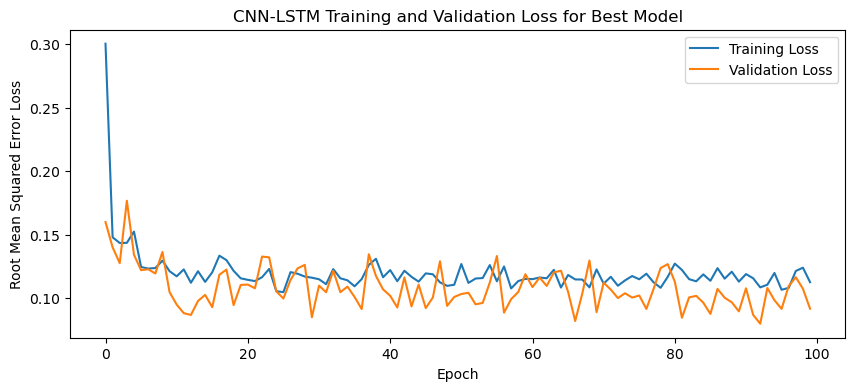

1/1 - 2s - loss: 0.1176 - 2s/epoch - 2s/step
Test Loss: 0.11760624498128891


NameError: name 'make_forecasts' is not defined

In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

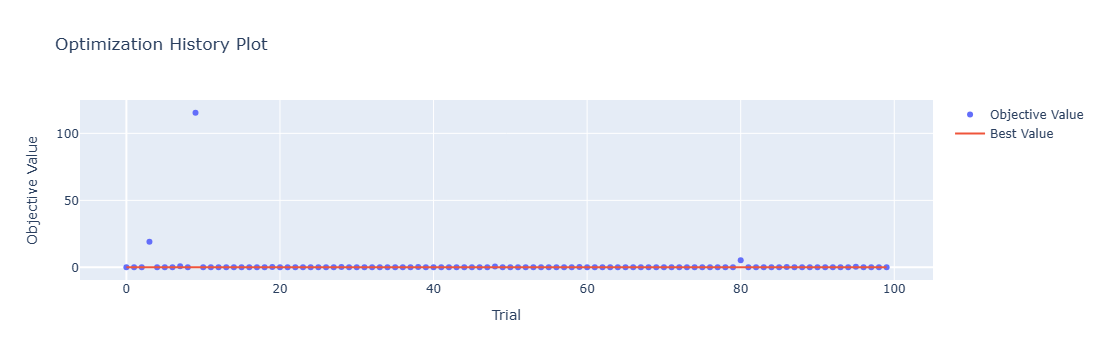

In [4]:
optuna.visualization.plot_optimization_history(study)

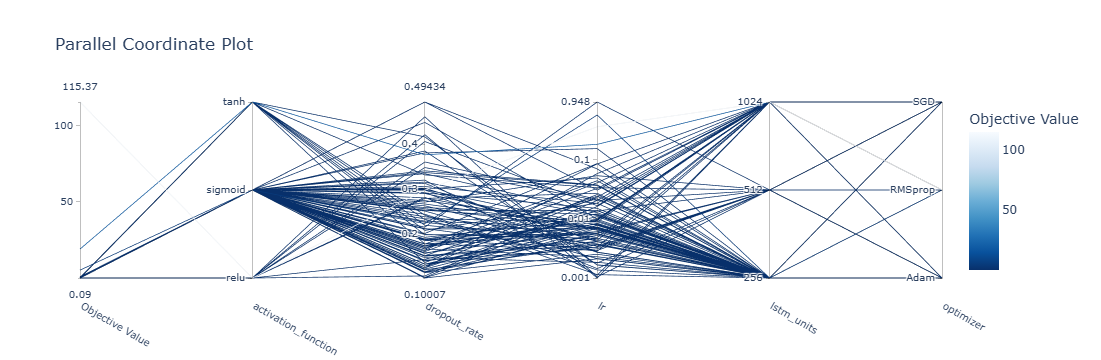

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

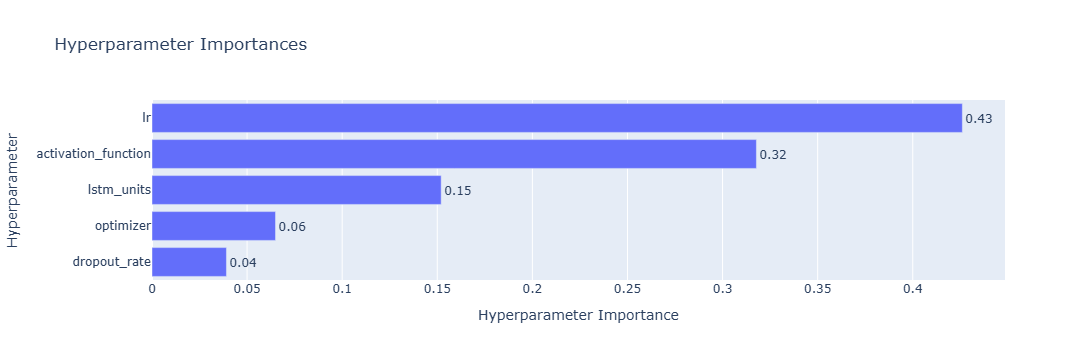

In [6]:
optuna.visualization.plot_param_importances(study)

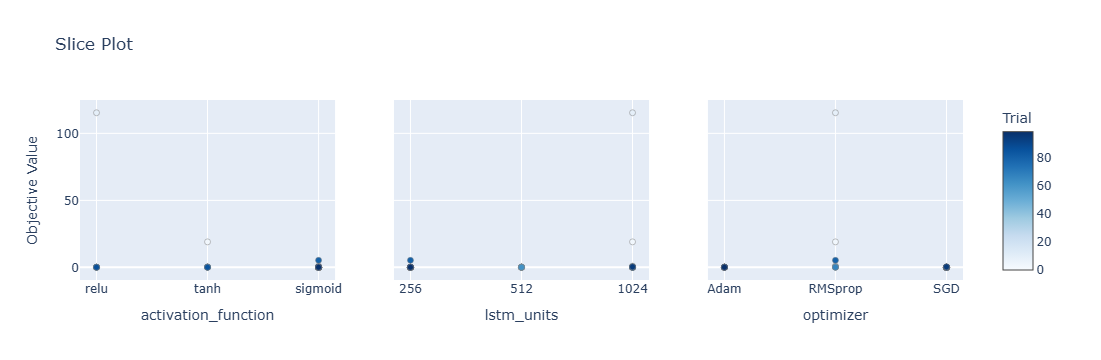

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

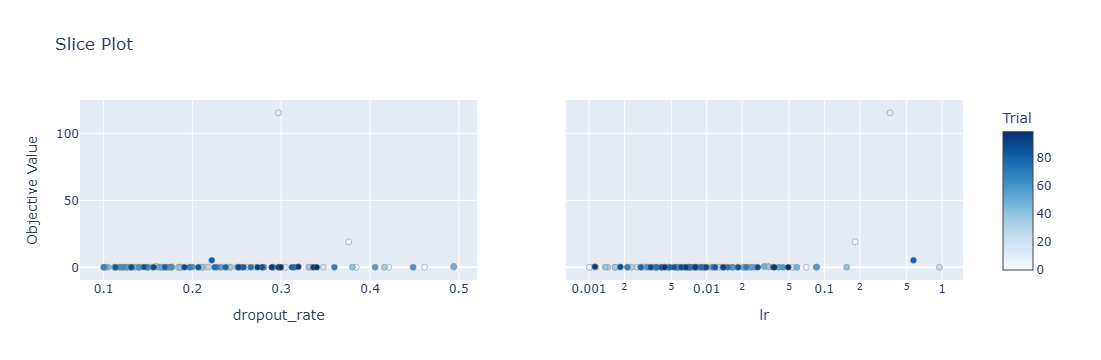

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 5s 73ms/step - loss: 0.3344 - accuracy: 0.0000e+00 - mae: 0.2732 - rmse: 0.3344 - mape: 51.6321 - pearson: 0.1215 - val_loss: 0.1329 - val_accuracy: 0.3333 - val_mae: 0.1124 - val_rmse: 0.1329 - val_mape: 20.6265 - val_pearson: 0.0410
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1858 - accuracy: 0.2632 - mae: 0.1556 - rmse: 0.1858 - mape: 28.5553 - pearson: 0.3593 - val_loss: 0.3040 - val_accuracy: 0.3333 - val_mae: 0.2461 - val_rmse: 0.3040 - val_mape: 42.7254 - val_pearson: 0.5080
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1693 - accuracy

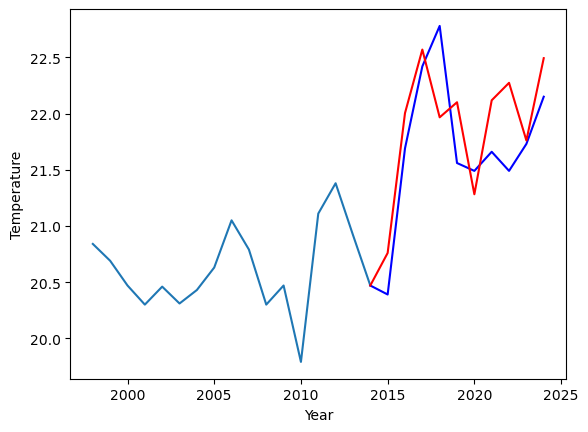

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.49		0.12
17.64		17.74		0.10
17.80		18.30		0.50
18.04		17.70		-0.34
18.00		17.83		-0.17
18.95		17.02		-1.93
18.12		17.85		-0.27
17.61		18.01		0.40
17.89		17.49		-0.40
17.72		18.22		0.50


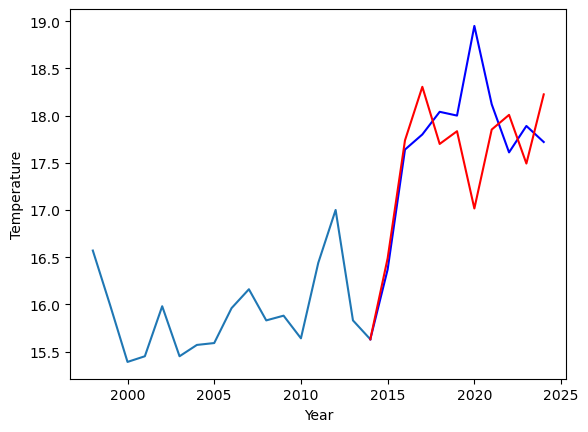

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.759464
1                1   16.37  16.488142


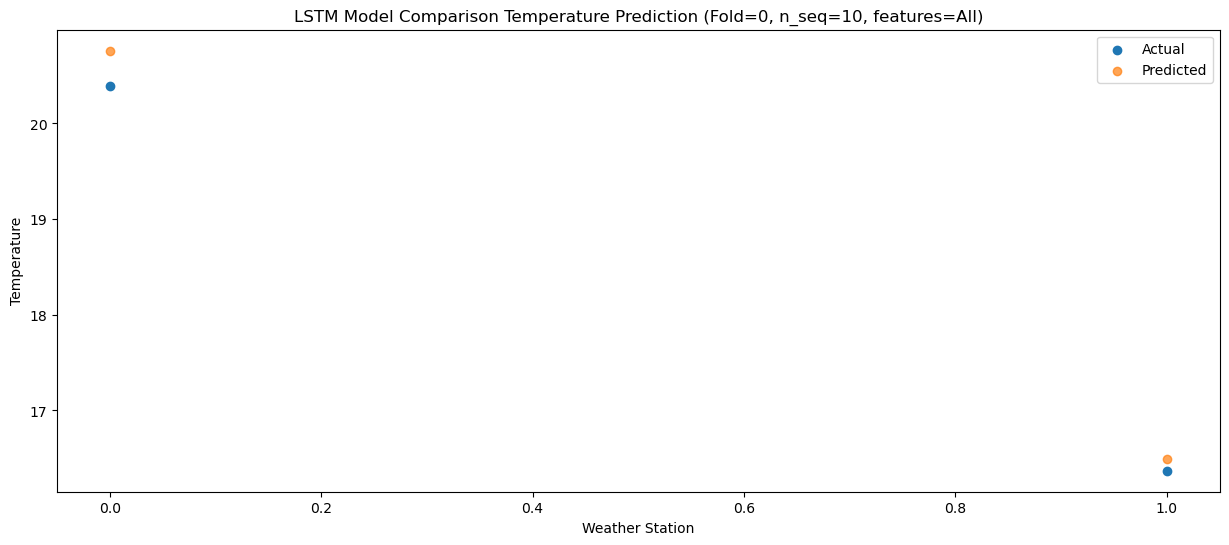

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  22.003948
1                1   17.64  17.737730


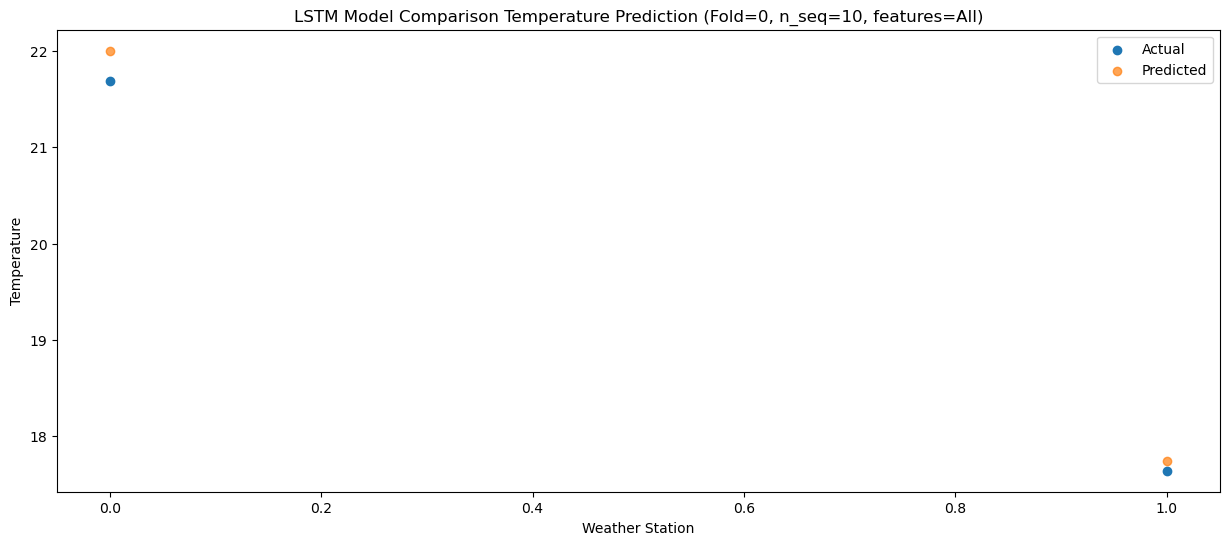

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.569552
1                1   17.80  18.304819


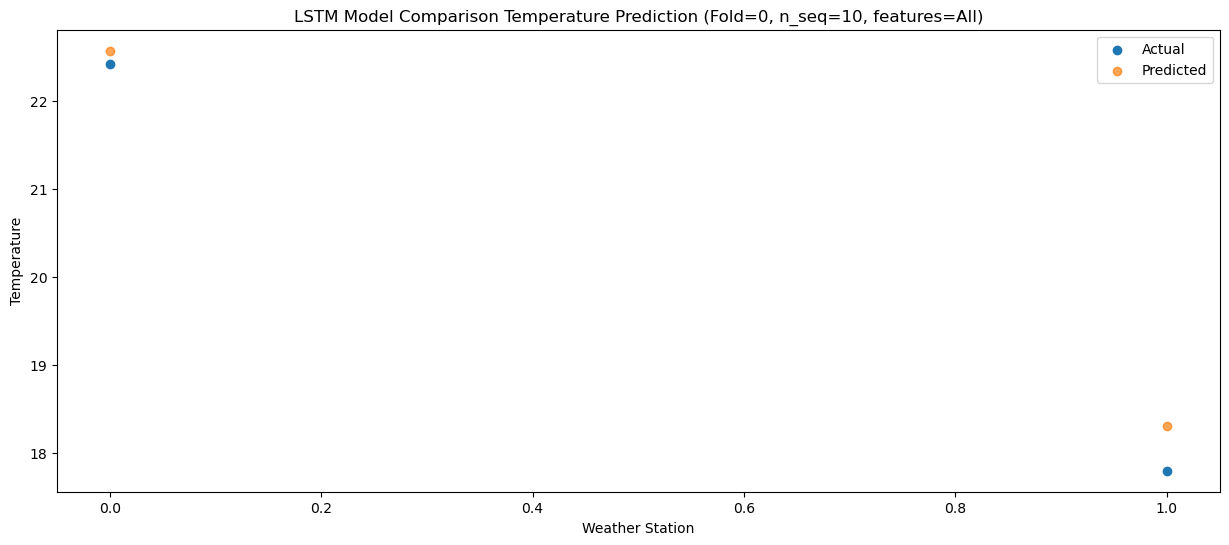

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  21.966685
1                1   18.04  17.699529


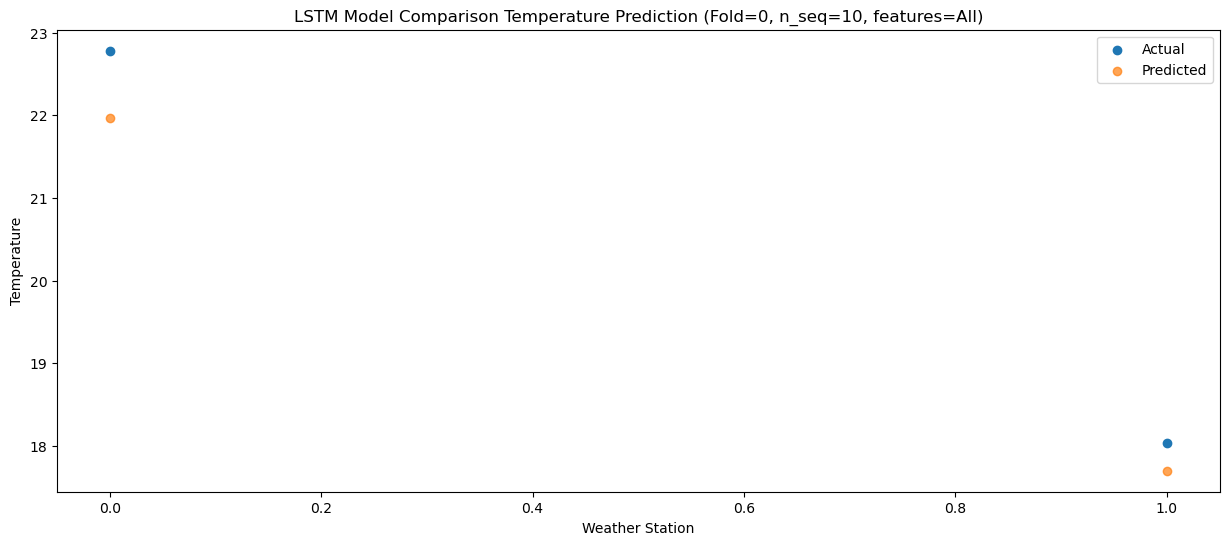

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  22.100833
1                1   18.00  17.834346


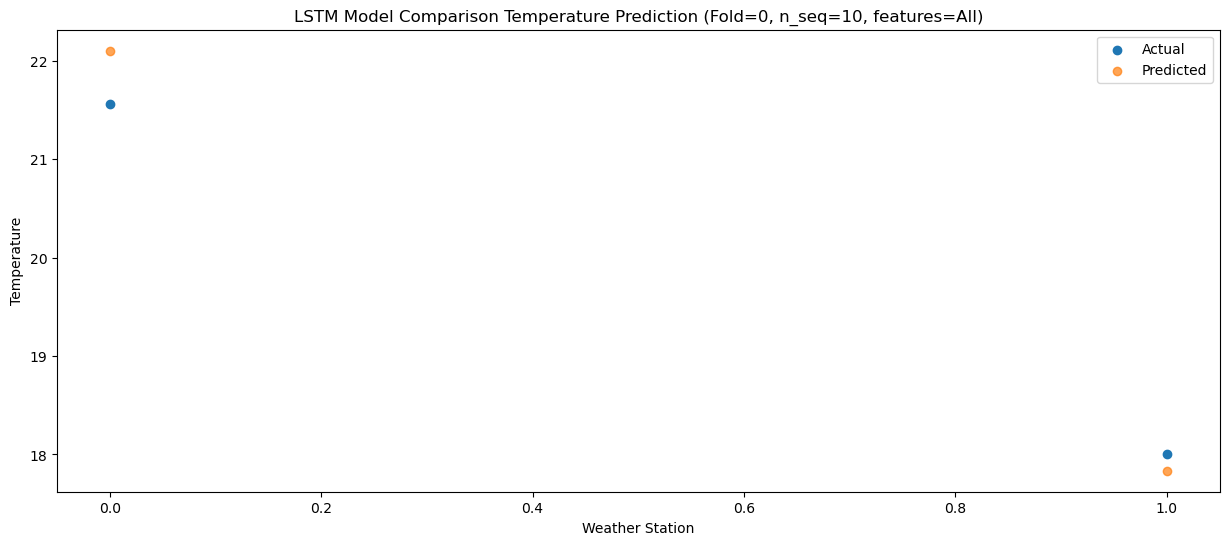

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.281790
1                1   18.95  17.015768


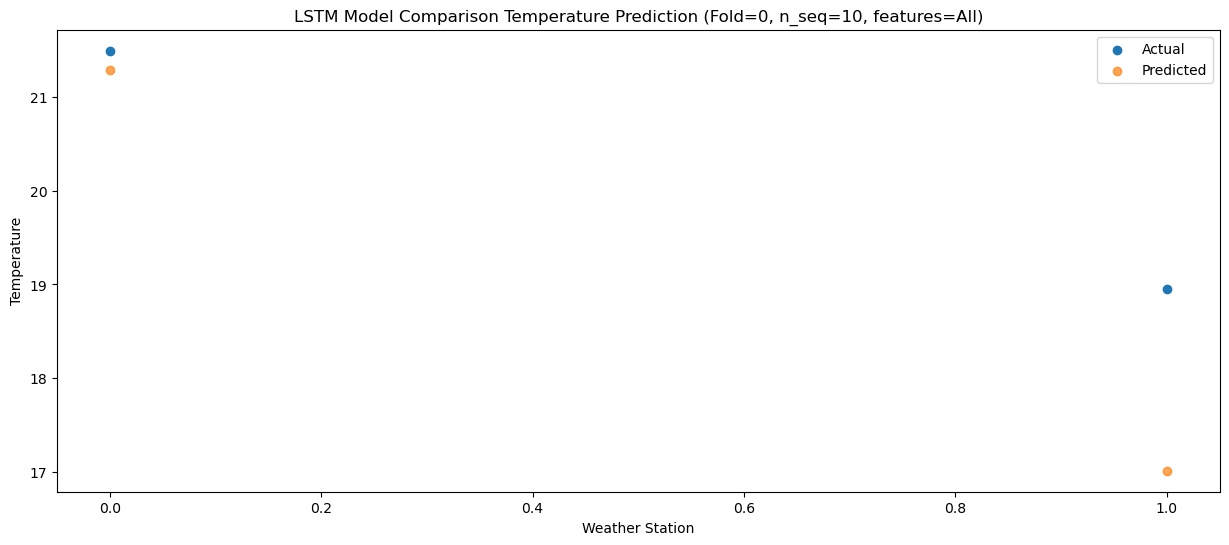

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  22.118207
1                1   18.12  17.852096


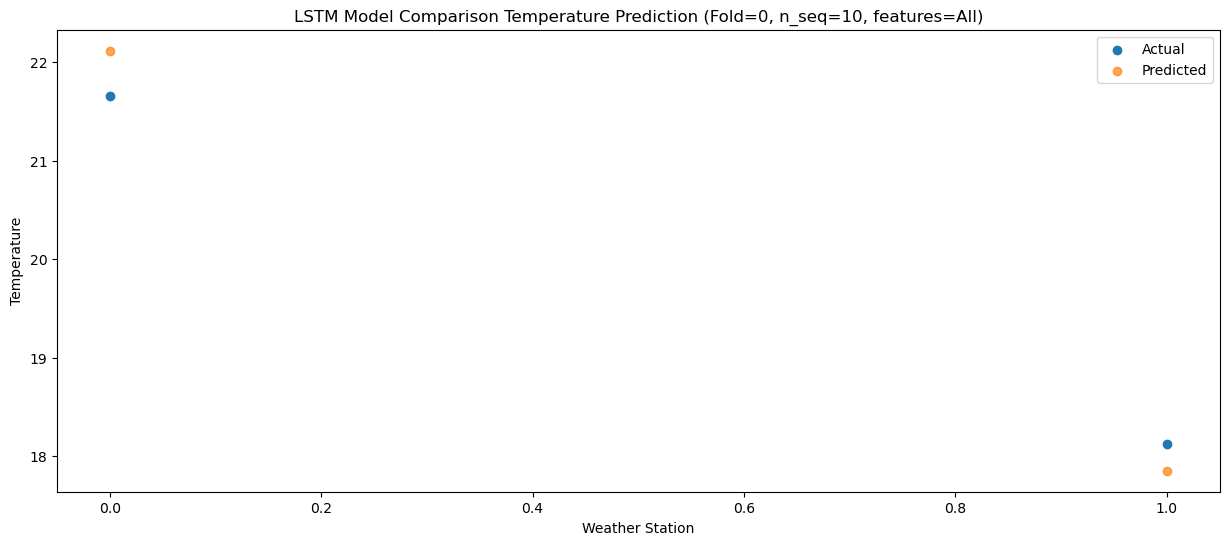

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  22.273612
1                1   17.61  18.007458


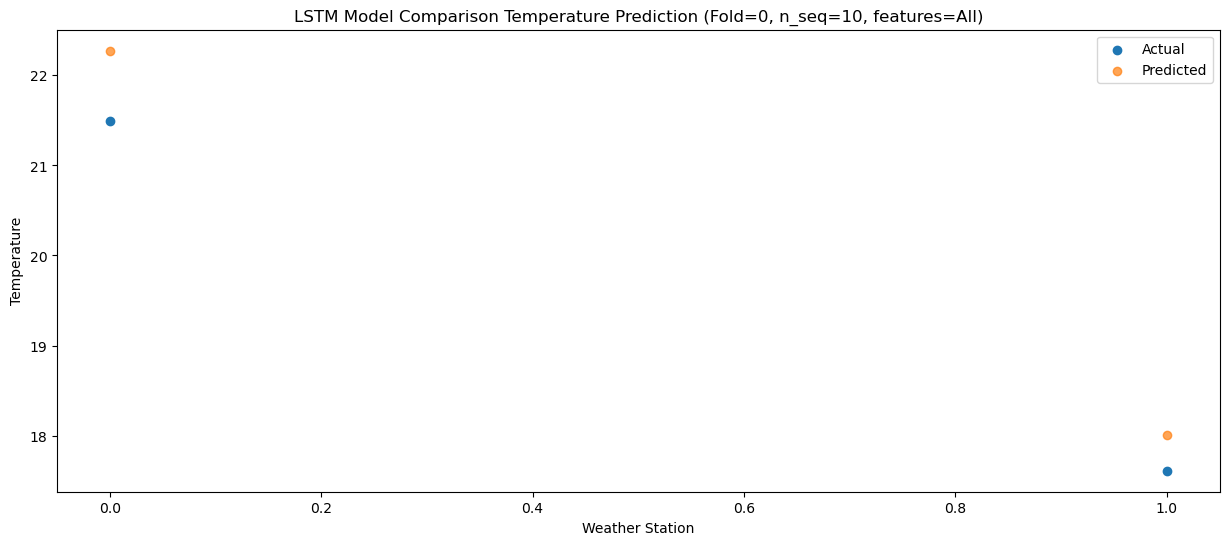

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  21.760620
1                1   17.89  17.491963


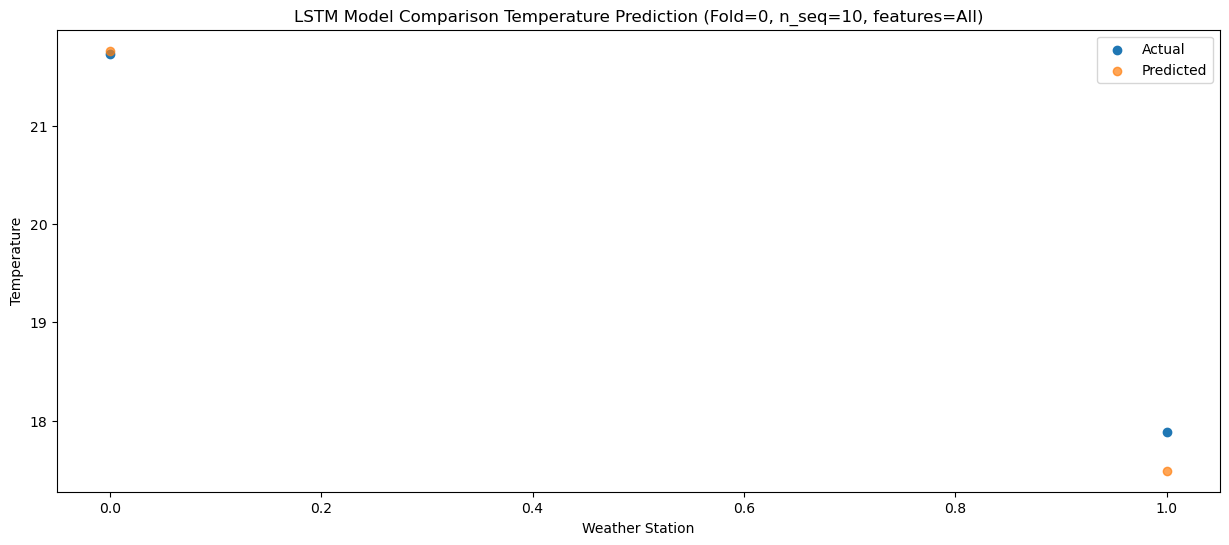

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  22.493062
1                1   17.72  18.224657


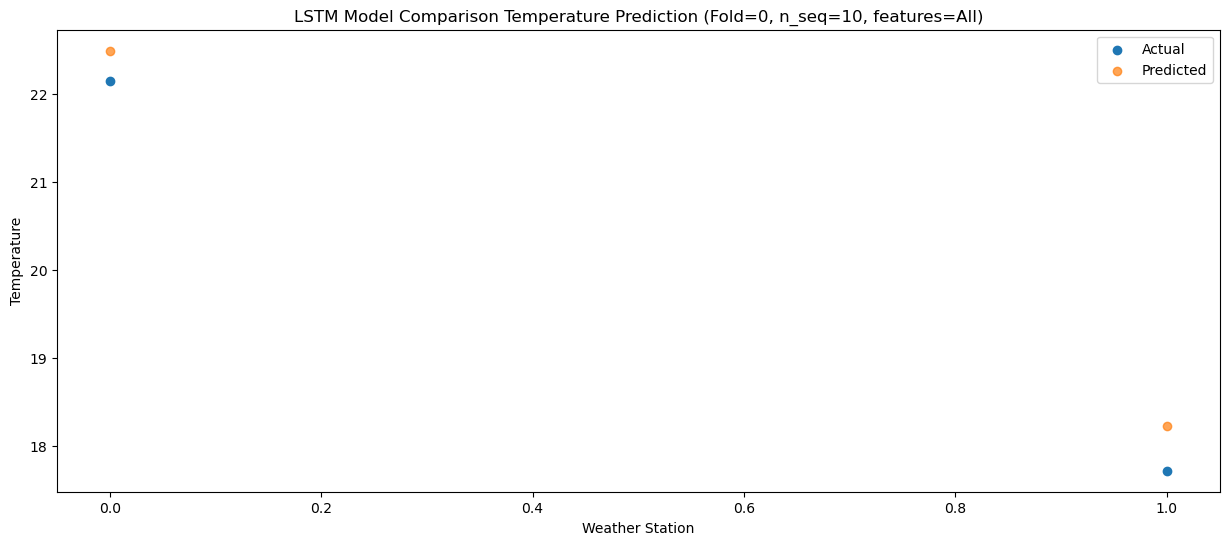

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.75946385 16.48814189]
 [22.0039478  17.73772978]
 [22.56955159 18.30481898]
 [21.96668488 17.69952904]
 [22.10083296 17.83434648]
 [21.28179028 17.01576836]
 [22.11820741 17.85209579]
 [22.27361197 18.0074584 ]
 [21.76062006 17.49196321]
 [22.49306238 18.22465724]]
Year at t+1:
t+1 SKRMSE: 0.274282
t+1 KRMSE: 0.274282
t+1 MAE: 0.243803
t+1 SKMAPE: 0.012668
t+1 R2_SCORE: 0.981379
t+1 KMAPE: 0.012668
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.232502
t+2 KRMSE: 0.232502
t+2 MAE: 0.205839
t+2 SKMAPE: 0.010007
t+2 R2_SCORE: 0.986817
t+2 KMAPE: 0.010007
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.372296
t+3 KRMSE: 0.372296
t+3 MAE: 0.327185
t+3 SKMAPE: 0.017516
t+3 R2_SCORE: 0.974025
t+3 KMAPE: 0.017516
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.623459
t+4 KRMSE: 0.623459
t+4 MAE: 0.576893
t+4 SKMAPE: 0.027288
t+4 R

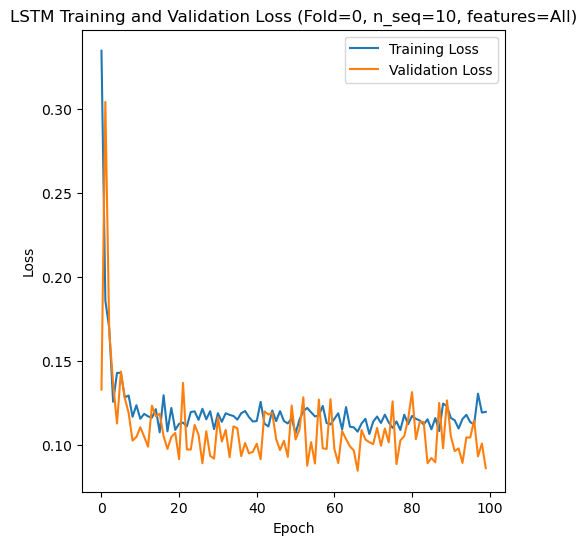

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 10s 160ms/step - loss: 0.2852 - accuracy: 0.1579 - mae: 0.2314 - rmse: 0.2852 - mape: 38.9633 - pearson: 0.2011 - val_loss: 0.2820 - val_accuracy: 0.0000e+00 - val_mae: 0.2455 - val_rmse: 0.2820 - val_mape: 42.0417 - val_pearson: 0.2943
Epoch 2/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1722 - accuracy: 0.2632 - mae: 0.1453 - rmse: 0.1722 - mape: 24.1918 - pearson: 0.4089 - val_loss: 0.1854 - val_accuracy: 0.0000e+00 - val_mae: 0.1519 - val_rmse: 0.1854 - val_mape: 24.5039 - val_pearson: 0.1504
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1569 - acc

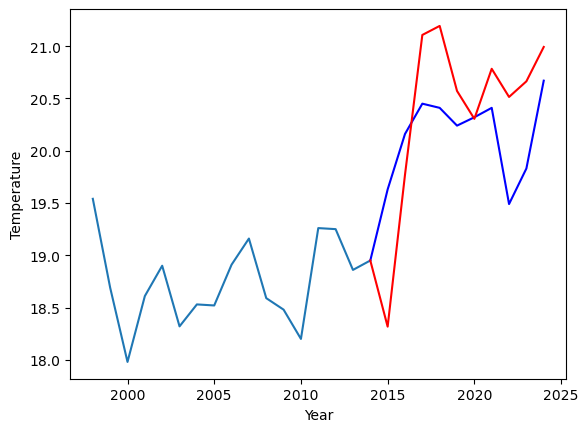

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		18.48		-1.40
19.40		19.92		0.52
20.43		21.26		0.83
20.81		21.35		0.54
19.96		20.72		0.76
20.09		20.46		0.37
20.61		20.93		0.32
20.22		20.66		0.44
20.22		20.81		0.59
21.53		21.14		-0.39


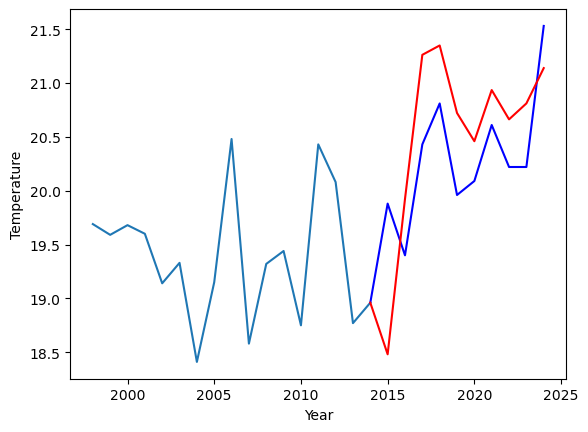

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  18.317316
1                1   19.88  18.480681


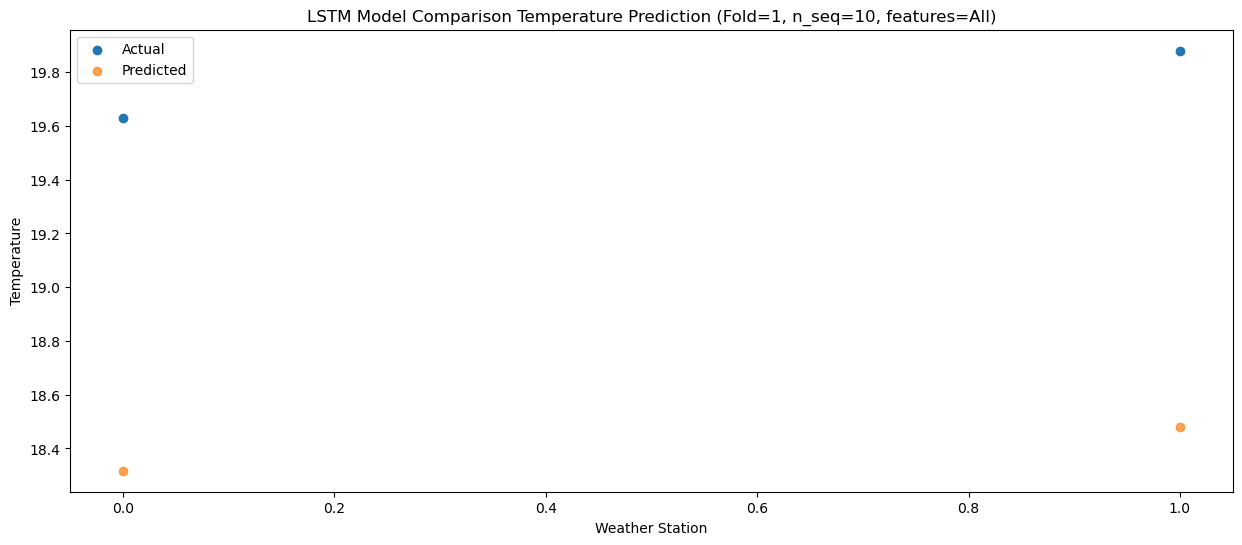

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  19.770034
1                1   19.40  19.923199


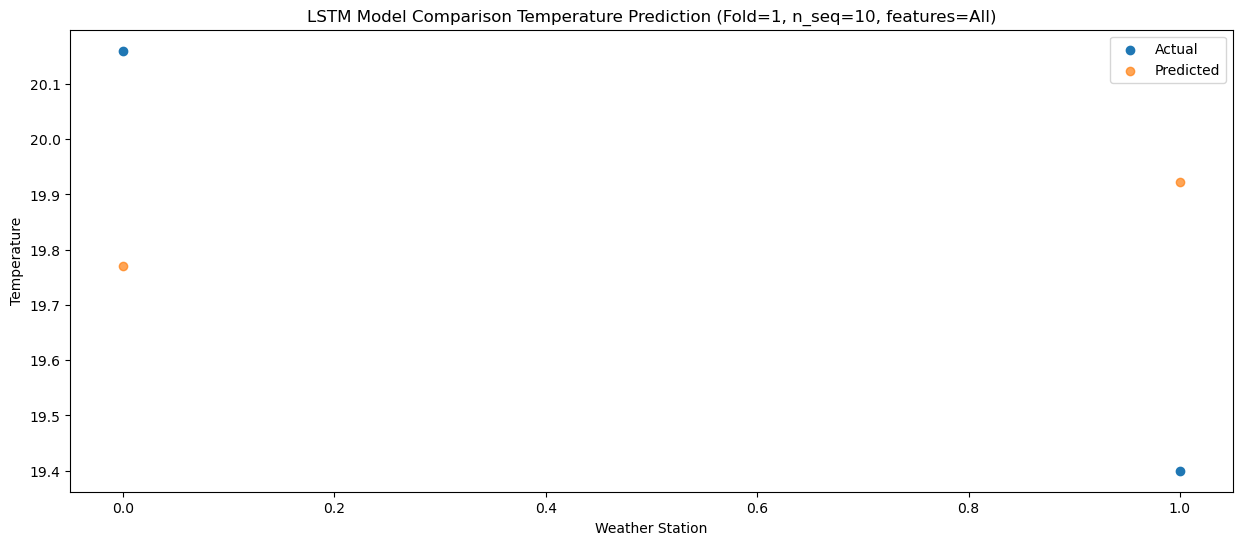

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  21.107218
1                1   20.43  21.261592


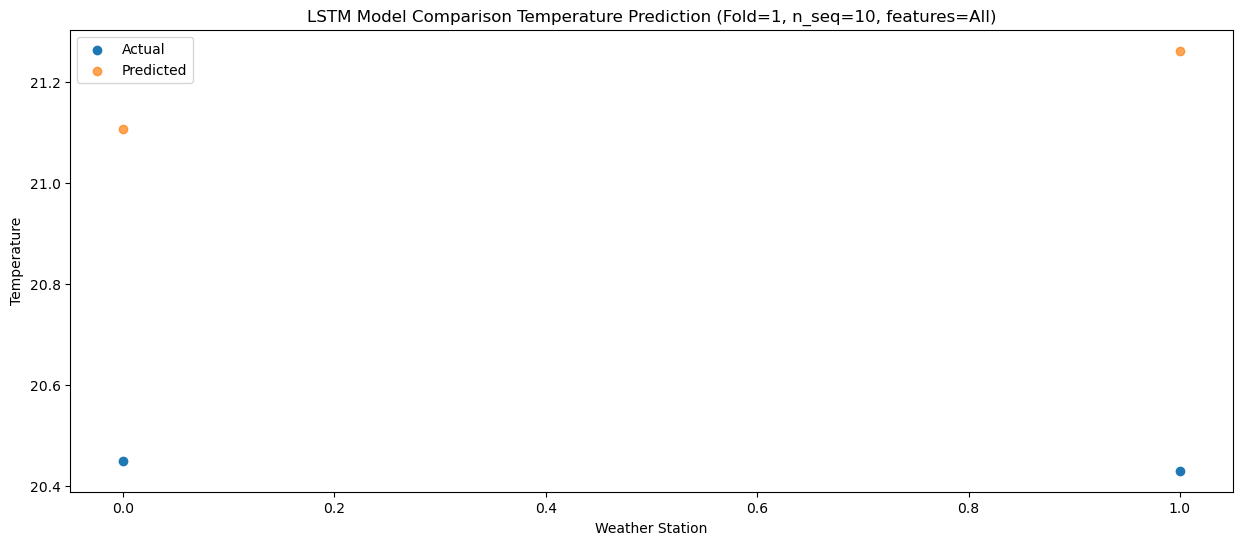

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41  21.193632
1                1   20.81  21.348563


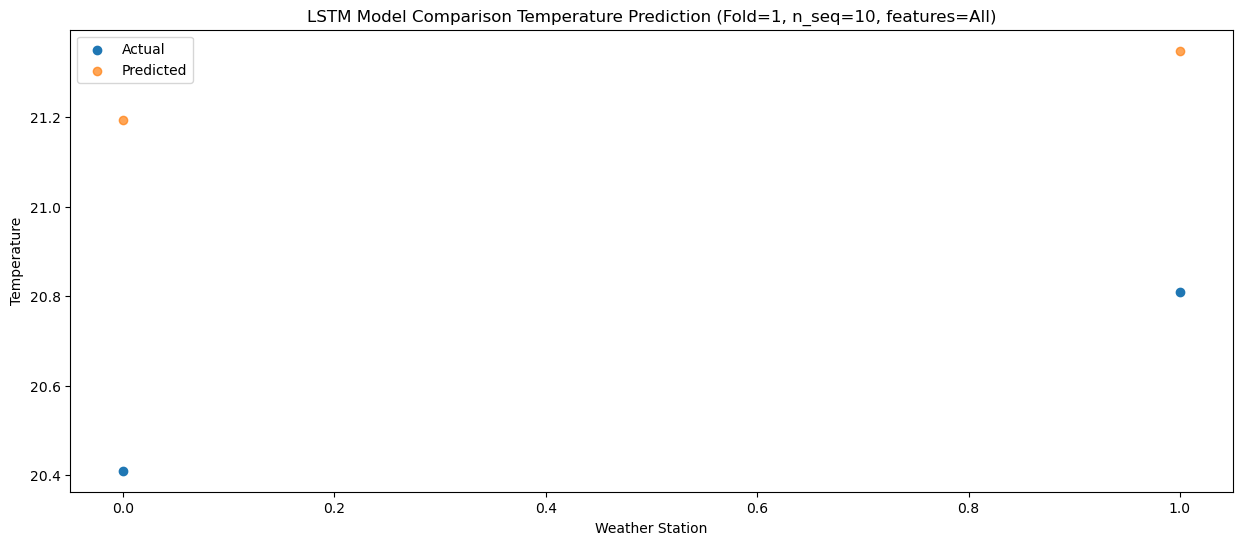

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  20.571845
1                1   19.96  20.721433


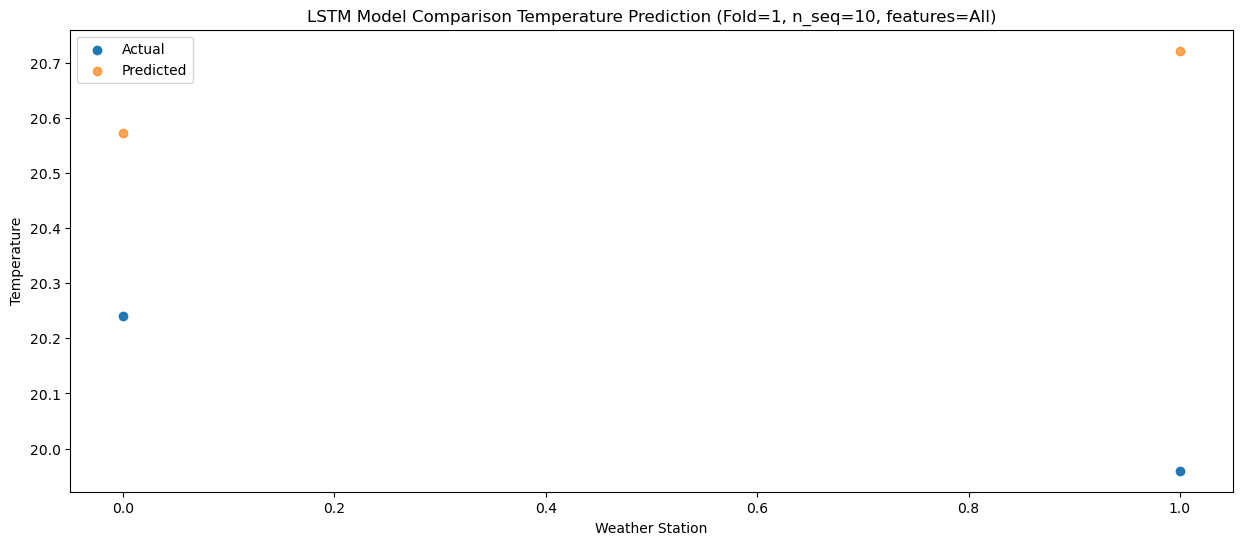

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  20.305015
1                1   20.09  20.459433


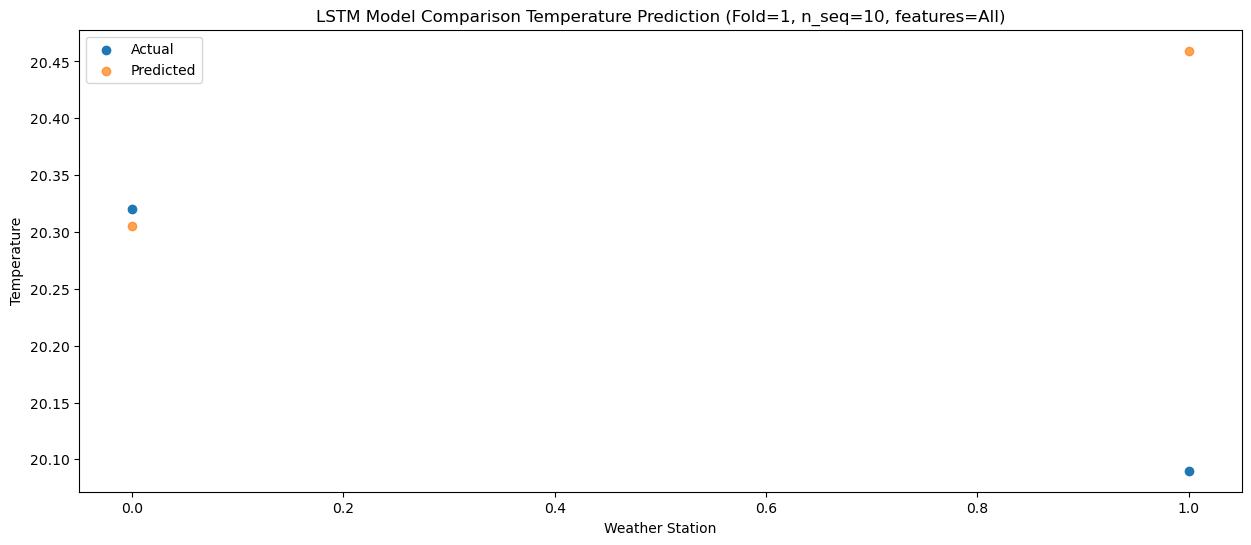

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  20.783651
1                1   20.61  20.934390


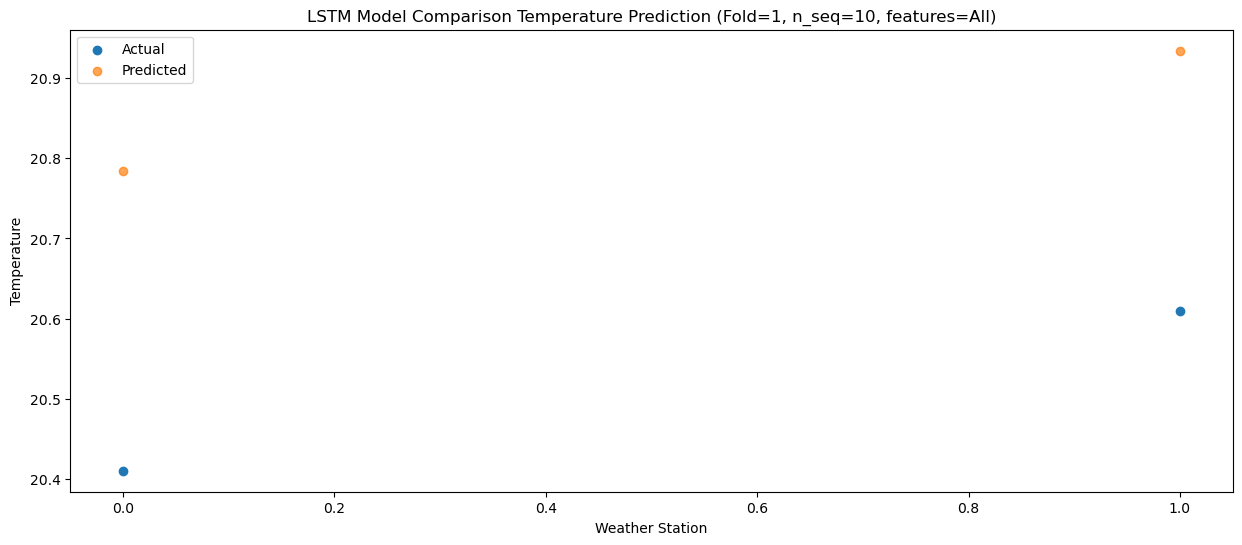

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  20.514239
1                1   20.22  20.662317


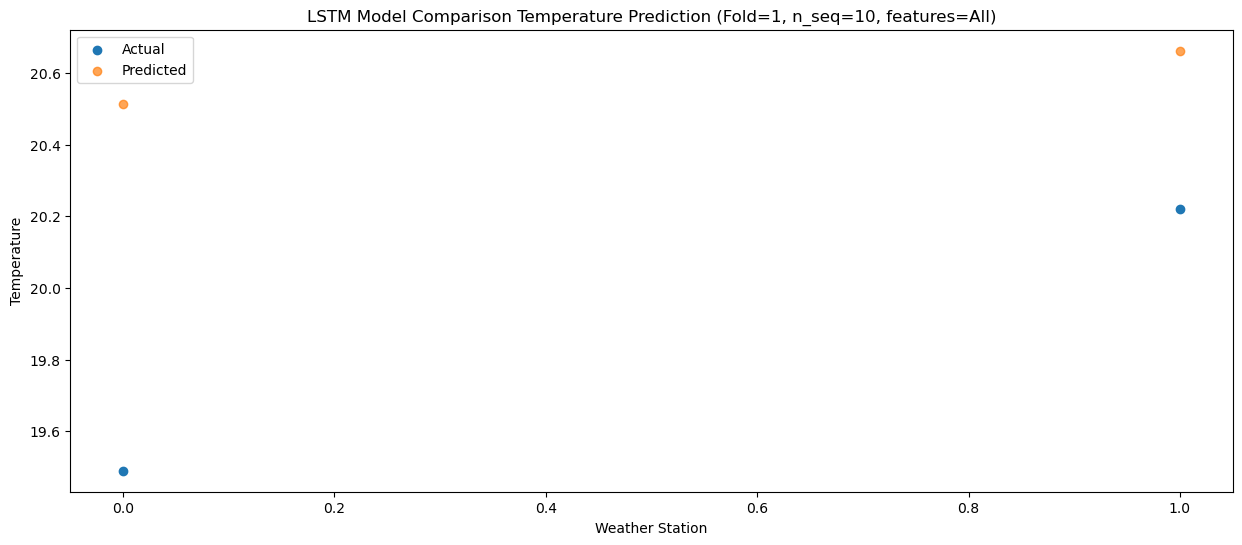

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  20.663758
1                1   20.22  20.810477


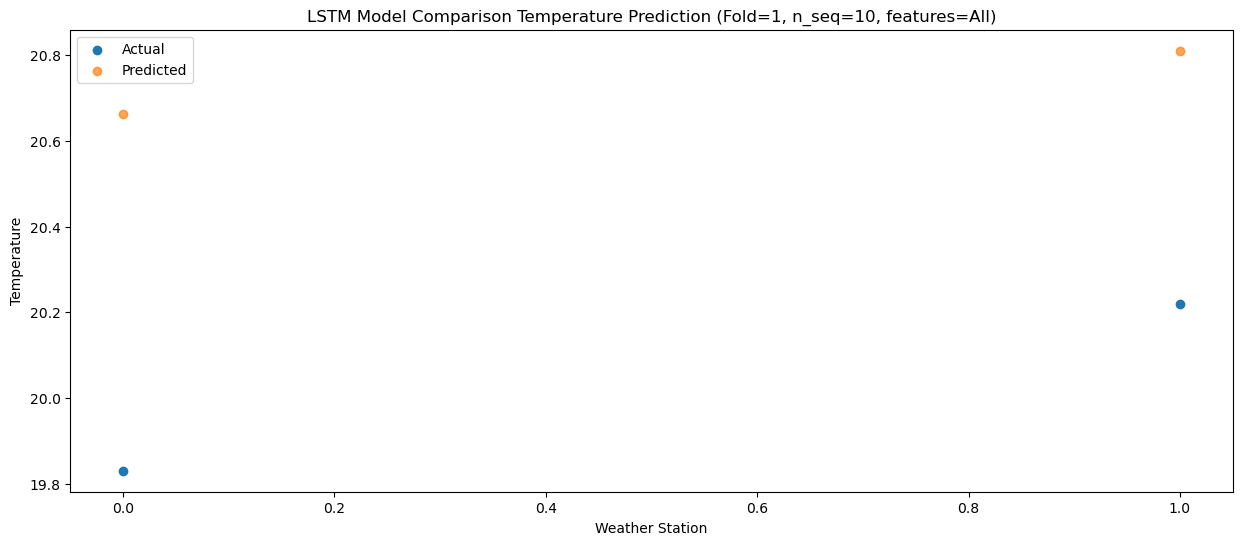

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  20.992435
1                1   21.53  21.138298


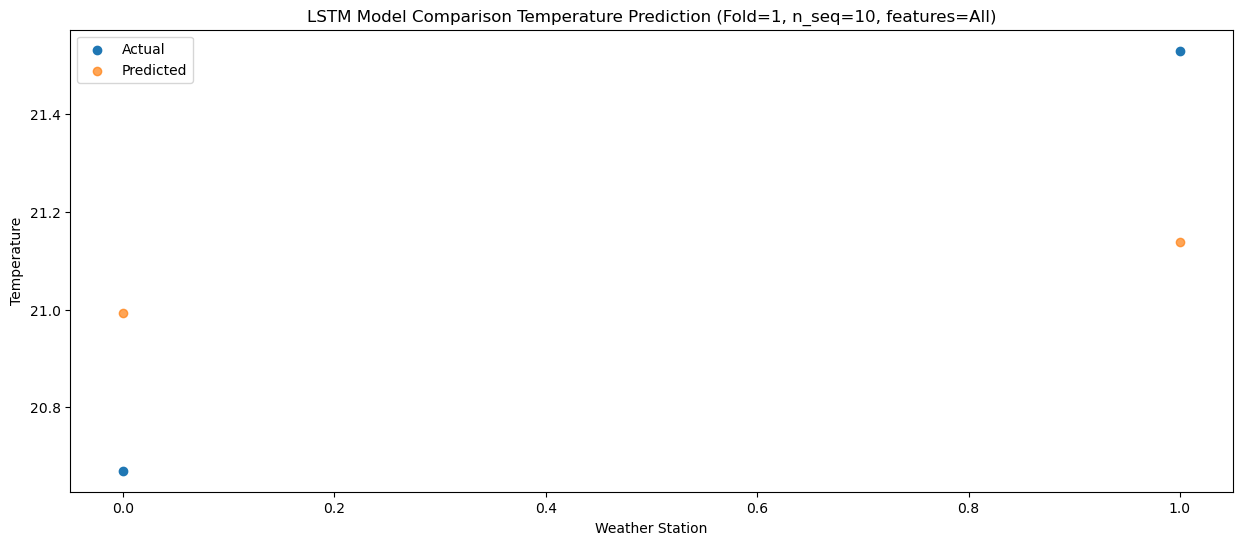

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[18.31731621 18.48068148]
 [19.77003399 19.92319888]
 [21.10721795 21.26159173]
 [21.1936319  21.34856336]
 [20.57184453 20.72143339]
 [20.30501507 20.4594333 ]
 [20.78365065 20.93439012]
 [20.51423888 20.6623167 ]
 [20.66375816 20.81047726]
 [20.99243486 21.13829753]]
Year at t+1:
t+1 SKRMSE: 1.356693
t+1 KRMSE: 1.356693
t+1 MAE: 1.356001
t+1 SKMAPE: 0.068630
t+1 R2_SCORE: -116.799393
t+1 KMAPE: 0.068630
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.461417
t+2 KRMSE: 0.461417
t+2 MAE: 0.456582
t+2 SKMAPE: 0.023156
t+2 R2_SCORE: -0.474413
t+2 KMAPE: 0.023156
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.749493
t+3 KRMSE: 0.749493
t+3 MAE: 0.744405
t+3 SKMAPE: 0.036421
t+3 R2_SCORE: -5616.401211
t+3 KMAPE: 0.036421
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.672358
t+4 KRMSE: 0.672358
t+4 MAE: 0.661098
t+4 SKMAPE: 0.0321

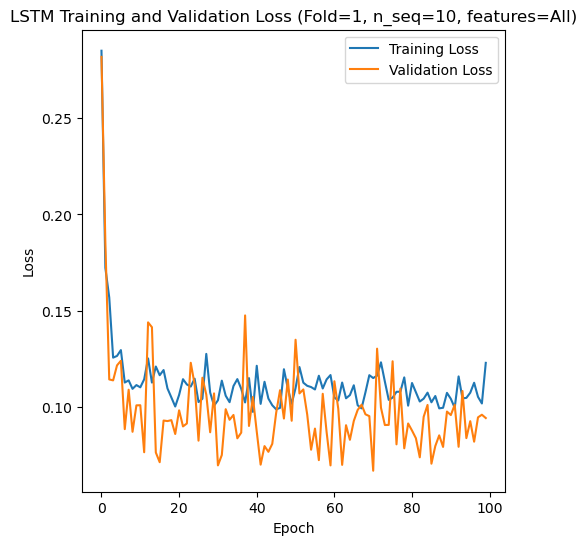

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 12s 132ms/step - loss: 0.3434 - accuracy: 0.0000e+00 - mae: 0.2967 - rmse: 0.3434 - mape: 48.3172 - pearson: 0.1632 - val_loss: 0.2168 - val_accuracy: 0.0000e+00 - val_mae: 0.1801 - val_rmse: 0.2168 - val_mape: 29.0288 - val_pearson: 0.4476
Epoch 2/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1896 - accuracy: 0.0526 - mae: 0.1567 - rmse: 0.1896 - mape: 26.1705 - pearson: 0.2956 - val_loss: 0.0733 - val_accuracy: 0.3333 - val_mae: 0.0636 - val_rmse: 0.0733 - val_mape: 10.4532 - val_pearson: 0.3625
Epoch 3/100
19/19 [==============================] - 0s 8ms/step - loss: 0.1353 - acc

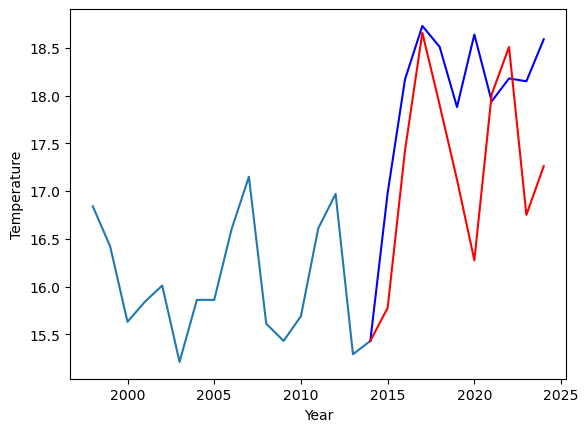

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		12.45		-0.44
14.23		14.09		-0.14
15.00		15.33		0.33
14.82		14.57		-0.25
14.35		13.79		-0.56
14.68		12.95		-1.73
14.67		14.68		0.01
14.66		15.18		0.52
14.20		13.42		-0.78
14.99		13.93		-1.06


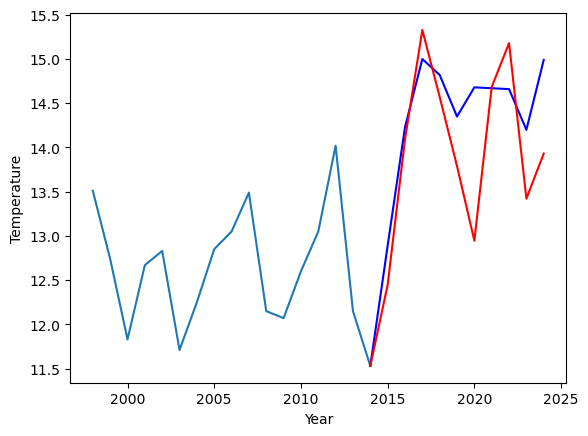

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  15.776046
1                1   12.89  12.445887


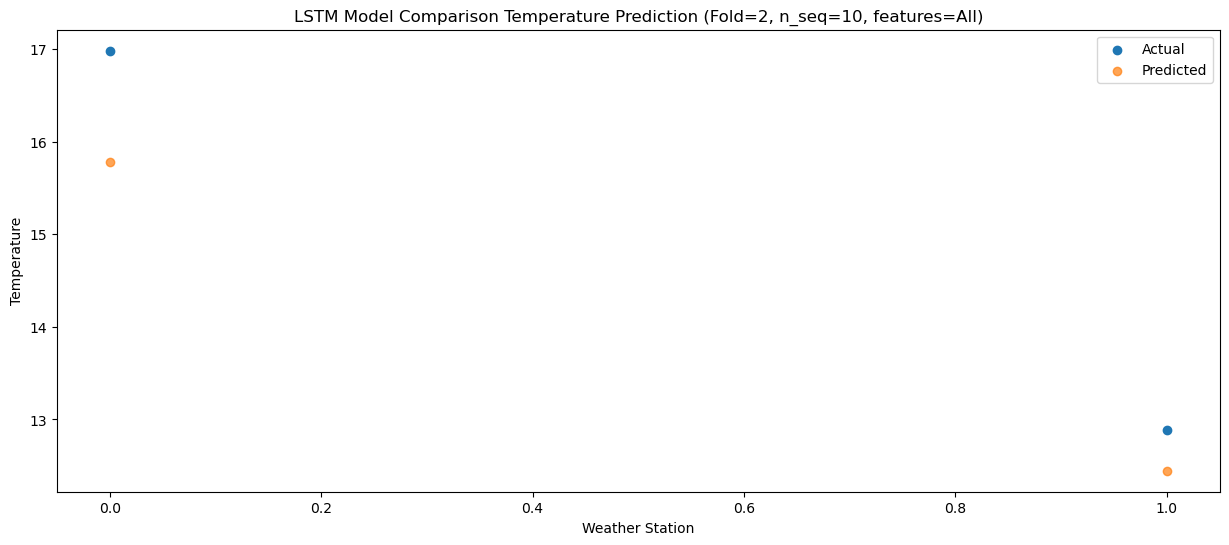

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.423615
1                1   14.23  14.093421


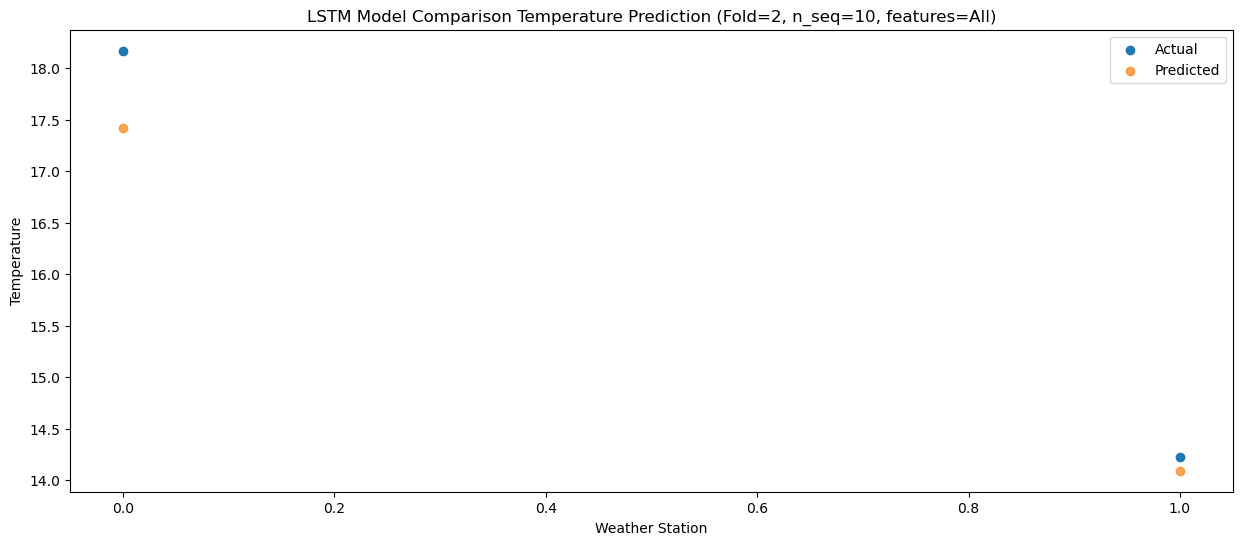

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73  18.659234
1                1   15.00  15.329416


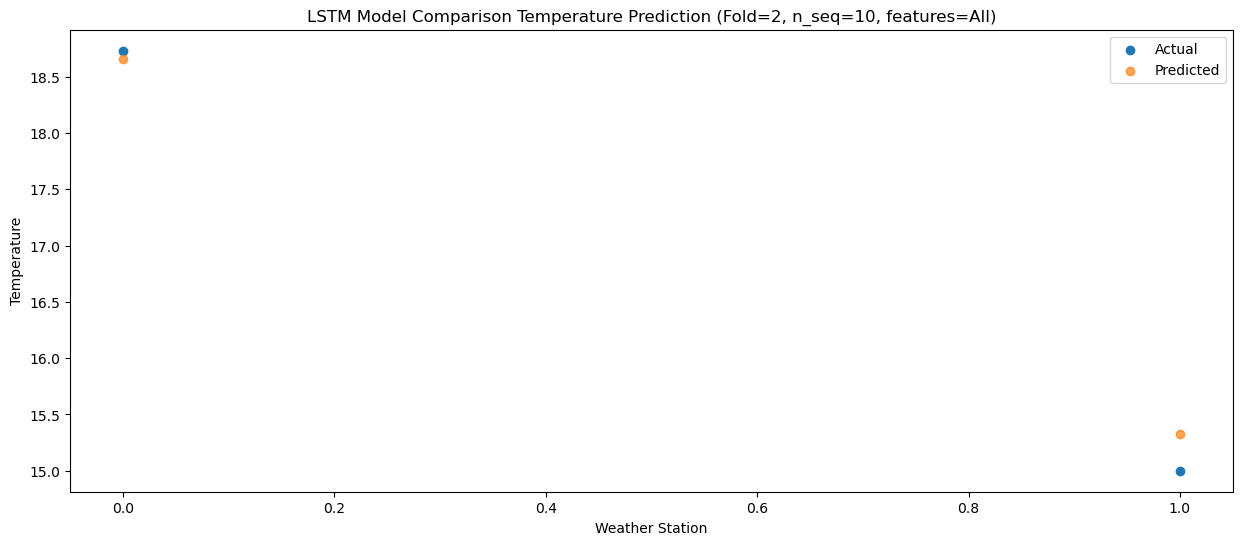

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  17.900848
1                1   14.82  14.571469


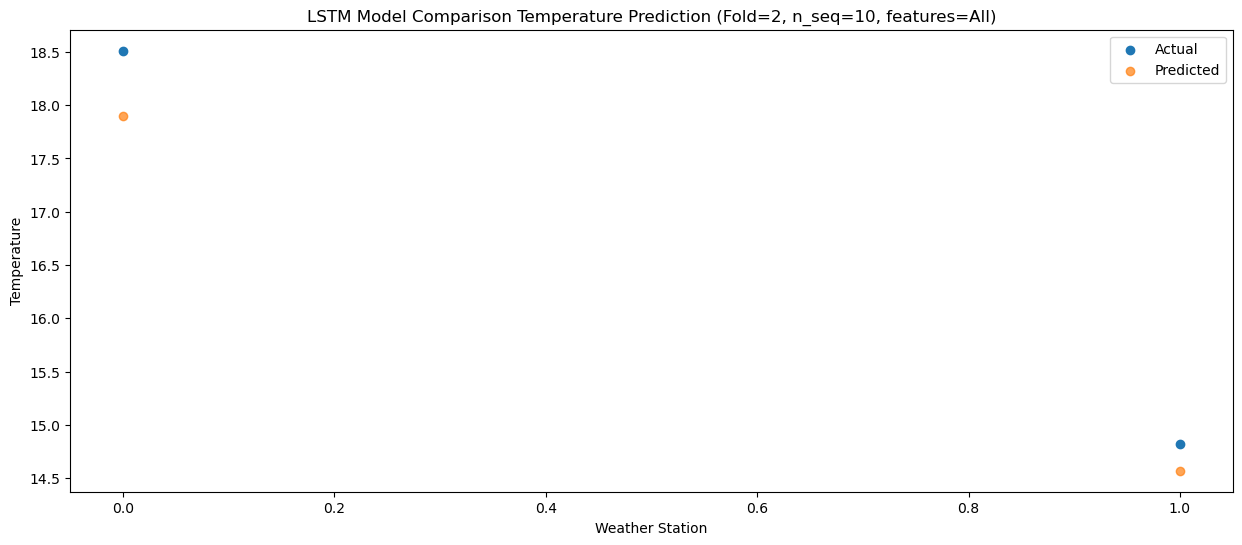

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88  17.118891
1                1   14.35  13.789552


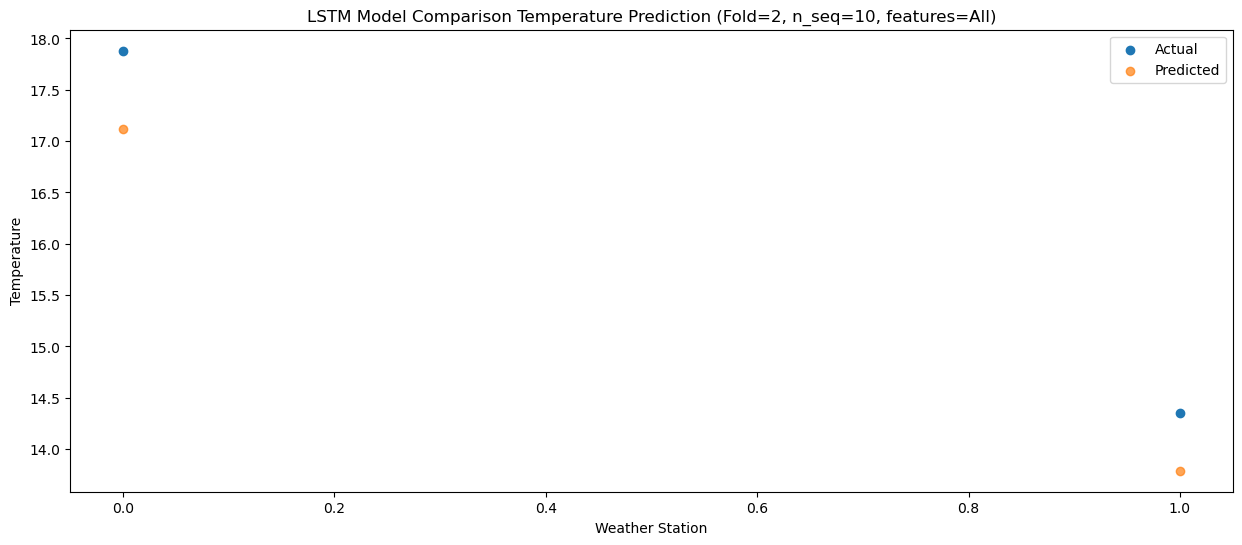

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  16.274363
1                1   14.68  12.945548


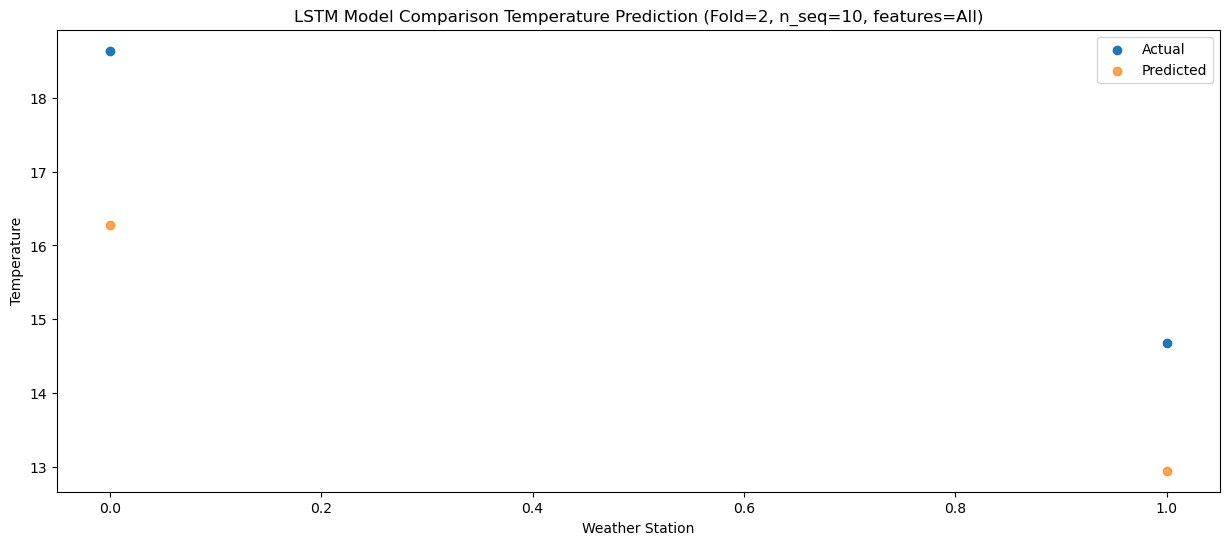

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  18.013758
1                1   14.67  14.684648


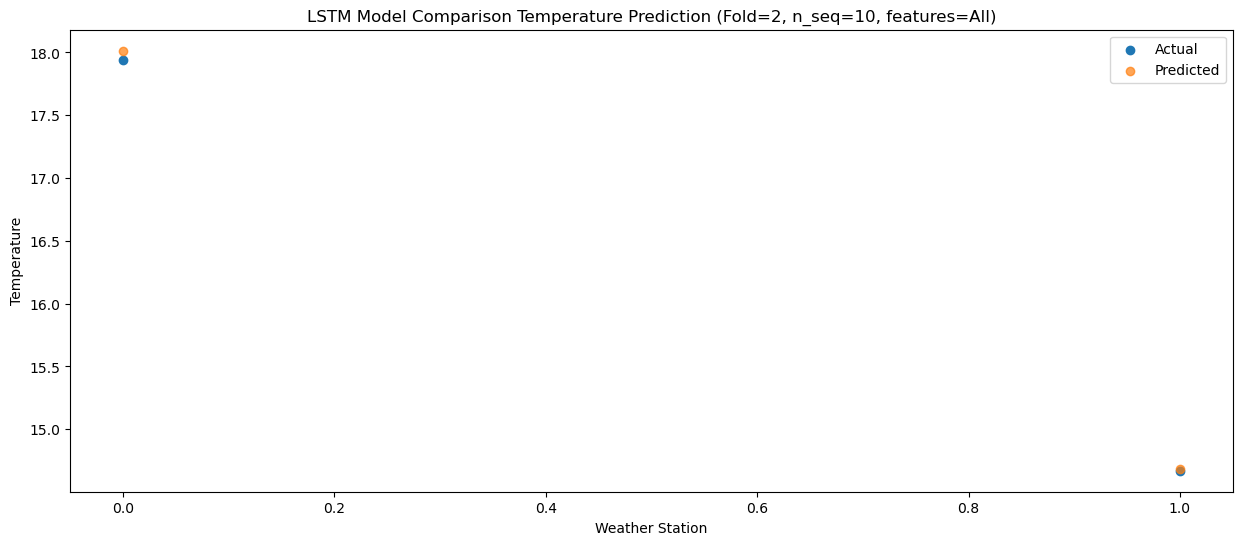

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  18.509358
1                1   14.66  15.180205


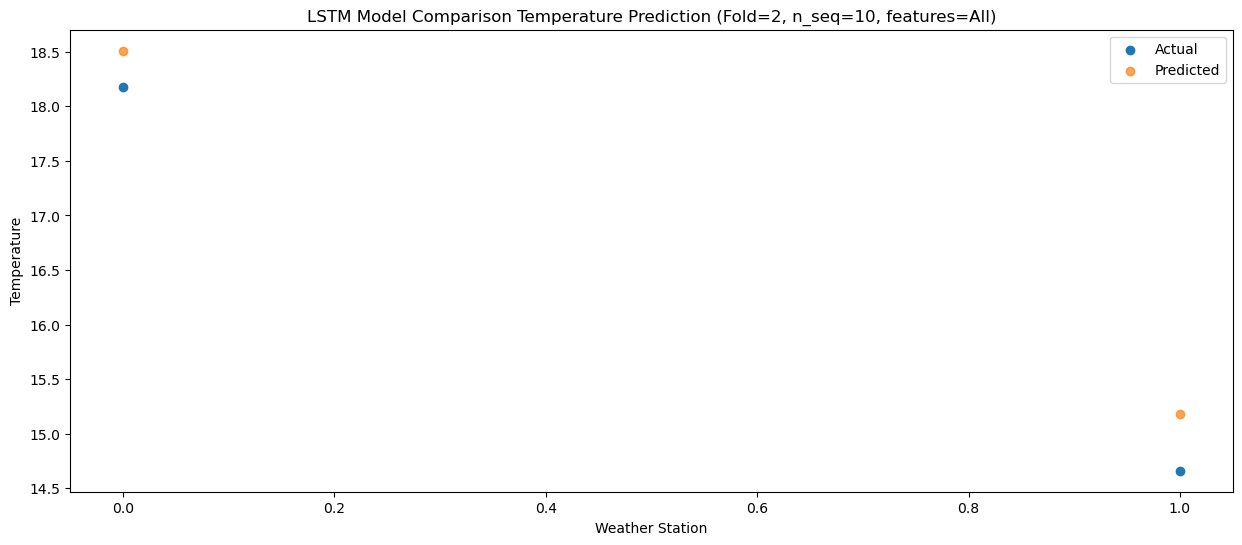

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  16.750188
1                1   14.20  13.421101


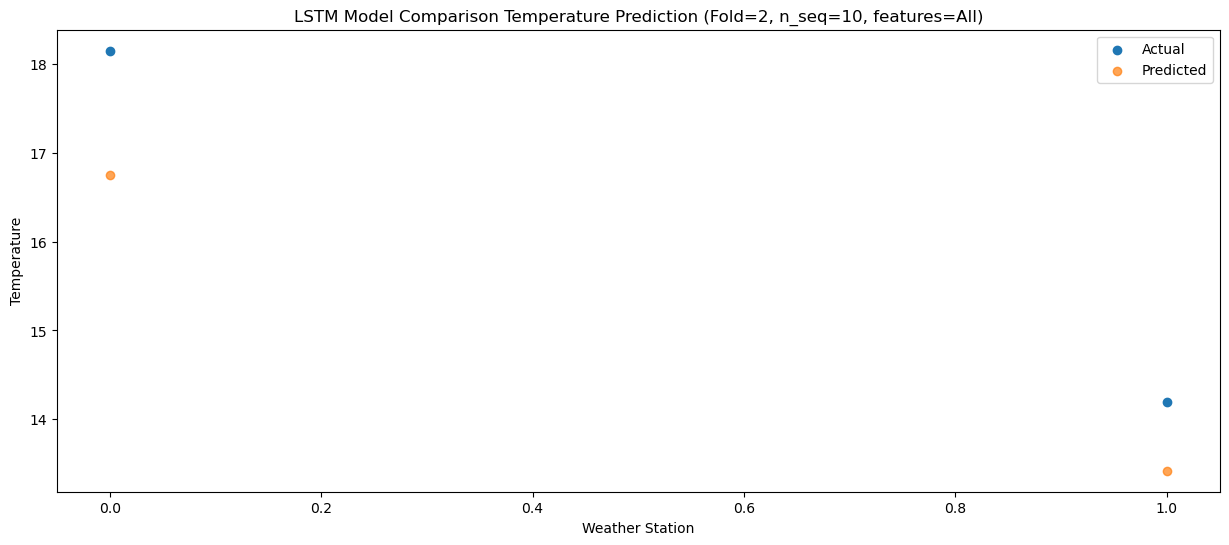

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59  17.260453
1                1   14.99  13.931557


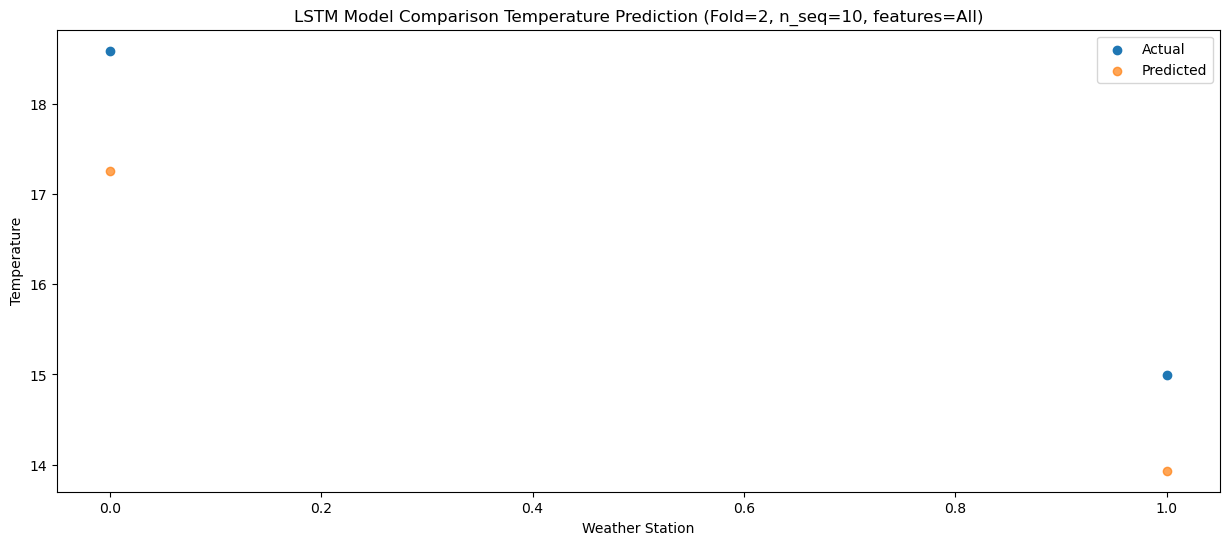

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[15.77604565 12.44588734]
 [17.42361459 14.09342099]
 [18.65923413 15.3294164 ]
 [17.90084847 14.57146884]
 [17.11889085 13.78955192]
 [16.27436253 12.94554831]
 [18.01375827 14.68464781]
 [18.5093581  15.18020527]
 [16.75018793 13.42110137]
 [17.26045256 13.93155734]]
Year at t+1:
t+1 SKRMSE: 0.907398
t+1 KRMSE: 0.907398
t+1 MAE: 0.824034
t+1 SKMAPE: 0.052679
t+1 R2_SCORE: 0.803117
t+1 KMAPE: 0.052679
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.536538
t+2 KRMSE: 0.536538
t+2 MAE: 0.441482
t+2 SKMAPE: 0.025338
t+2 R2_SCORE: 0.925823
t+2 KMAPE: 0.025338
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.238247
t+3 KRMSE: 0.238247
t+3 MAE: 0.200091
t+3 SKMAPE: 0.012870
t+3 R2_SCORE: 0.983681
t+3 KMAPE: 0.012870
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.465206
t+4 KRMSE: 0.465206
t+4 MAE: 0.428841
t+4 SKMAPE: 0.024840
t+4 R

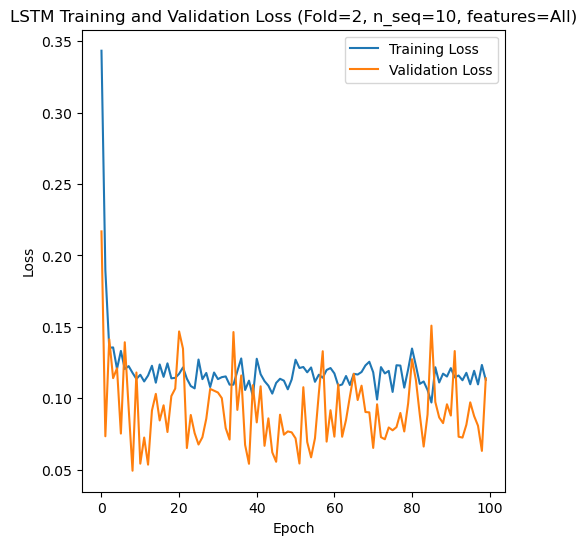

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 12s 154ms/step - loss: 0.2570 - accuracy: 0.2000 - mae: 0.2141 - rmse: 0.2570 - mape: 34.5210 - pearson: 0.1296 - val_loss: 0.1218 - val_accuracy: 0.0000e+00 - val_mae: 0.0940 - val_rmse: 0.1218 - val_mape: 14.7358 - val_pearson: 0.6759
Epoch 2/100
20/20 [==============================] - 0s 7ms/step - loss: 0.1387 - accuracy: 0.2000 - mae: 0.1160 - rmse: 0.1387 - mape: 18.5701 - pearson: 0.2626 - val_loss: 0.1877 - val_accuracy: 0.0000e+00 - val_mae: 0.1525 - val_rmse: 0.1877 - val_mape: 24.6957 - val_pearson: 0.1044
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.1307 - accu

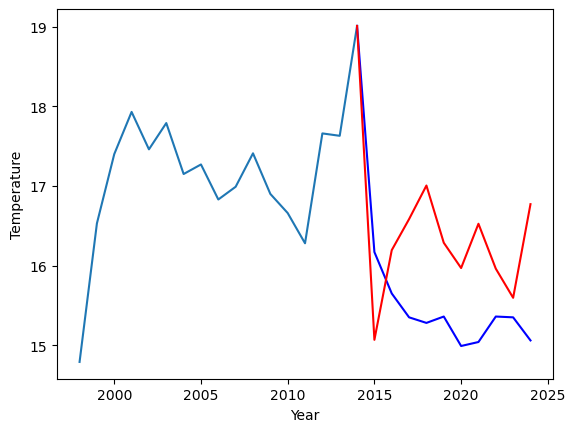

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		14.34		1.31
14.13		15.46		1.33
15.42		15.85		0.43
15.25		16.27		1.02
14.76		15.55		0.79
15.17		15.24		0.07
15.05		15.79		0.74
14.85		15.23		0.38
14.55		14.86		0.31
15.57		16.04		0.47


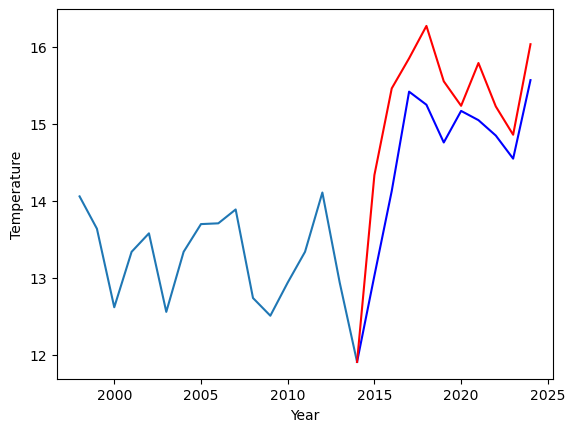

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  15.067597
1                1   13.03  14.336386


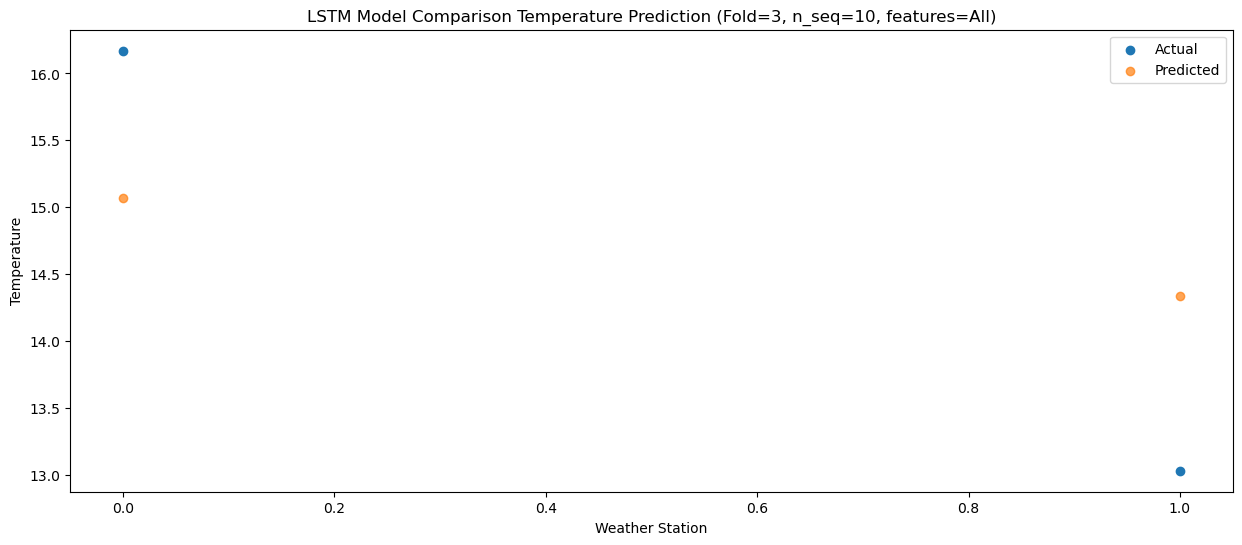

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  16.193460
1                1   14.13  15.462471


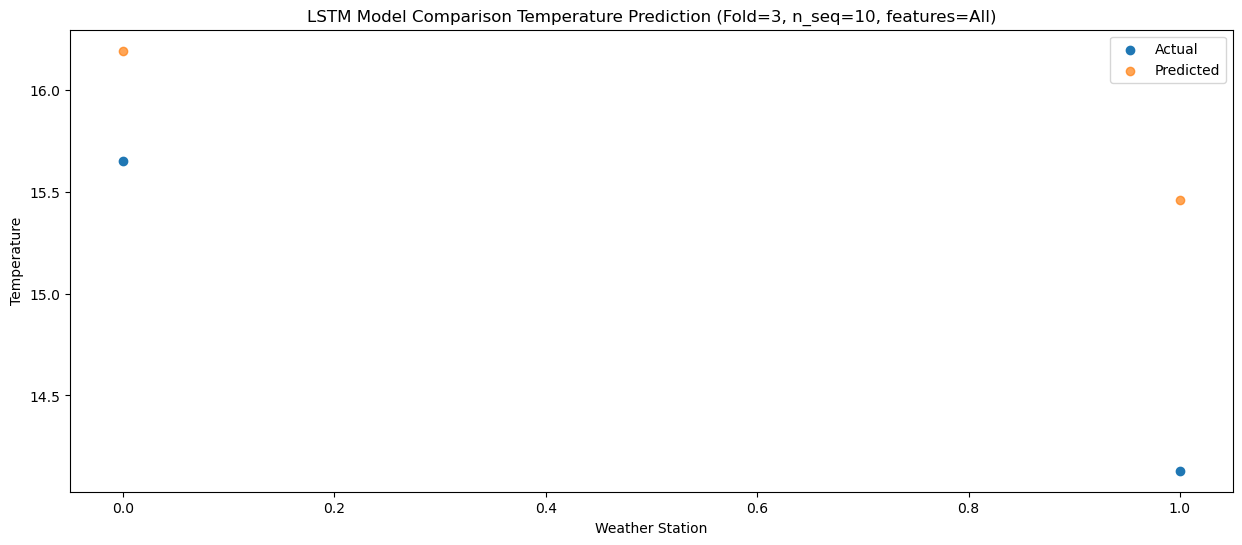

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.583823
1                1   15.42  15.852810


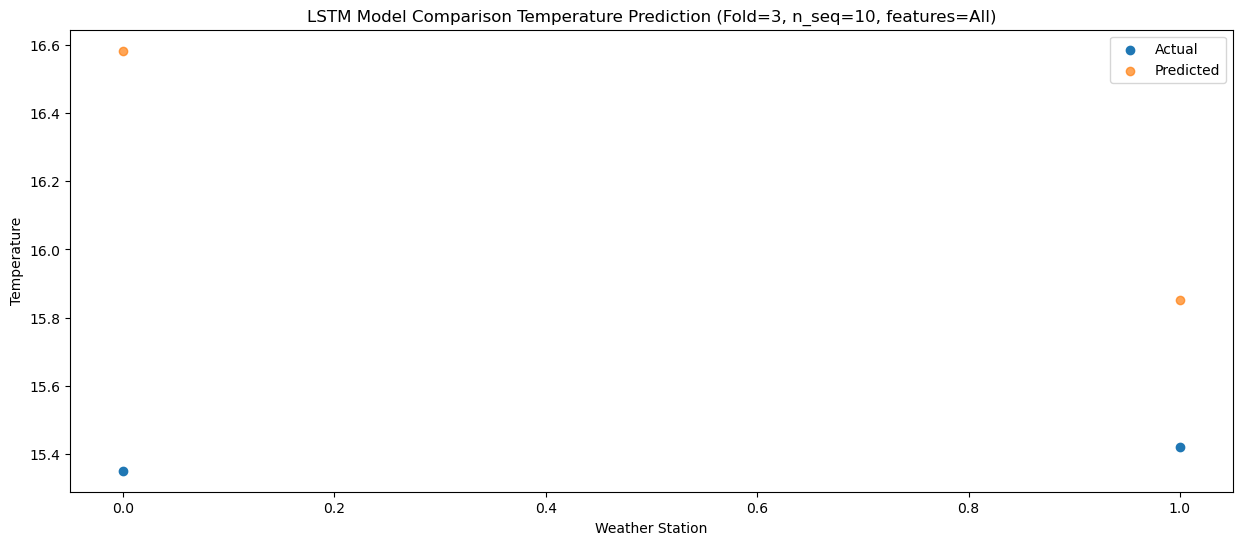

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  17.005528
1                1   15.25  16.273841


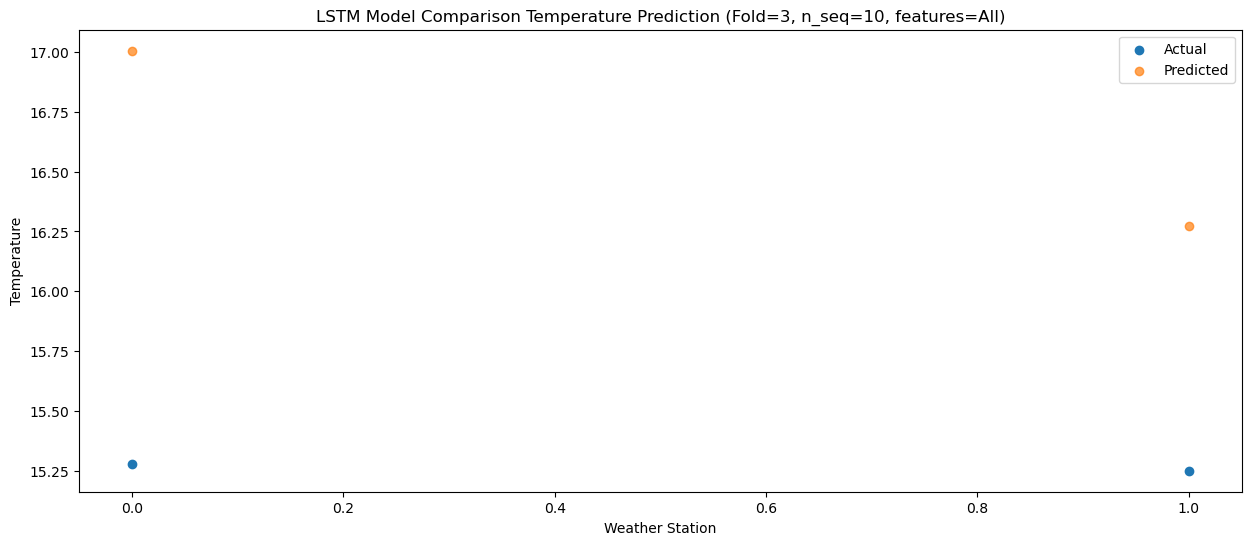

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  16.286684
1                1   14.76  15.554445


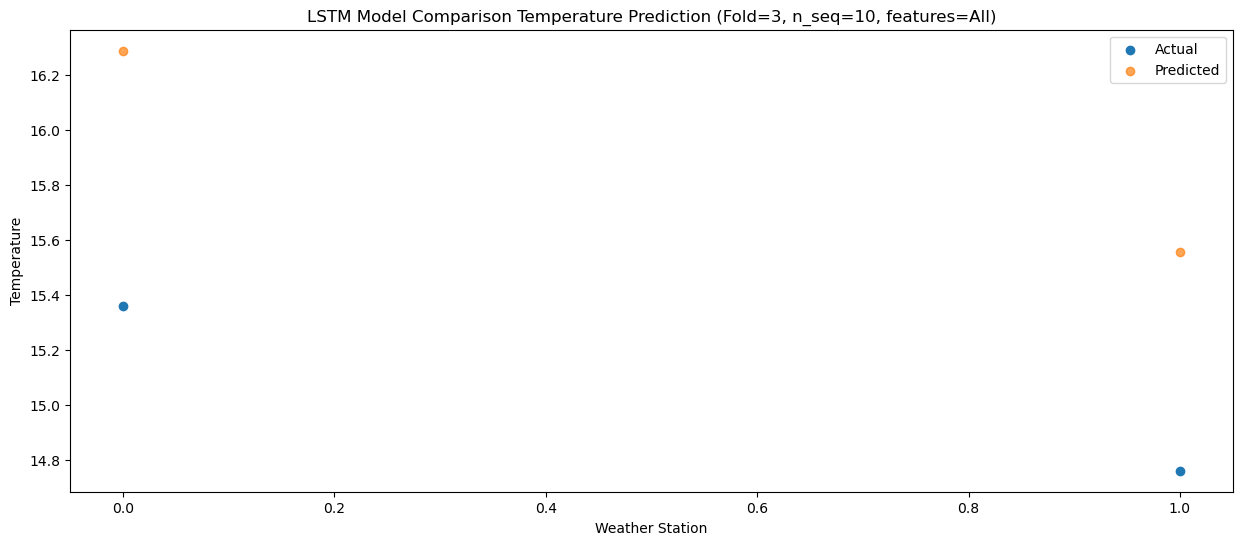

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.969163
1                1   15.17  15.236406


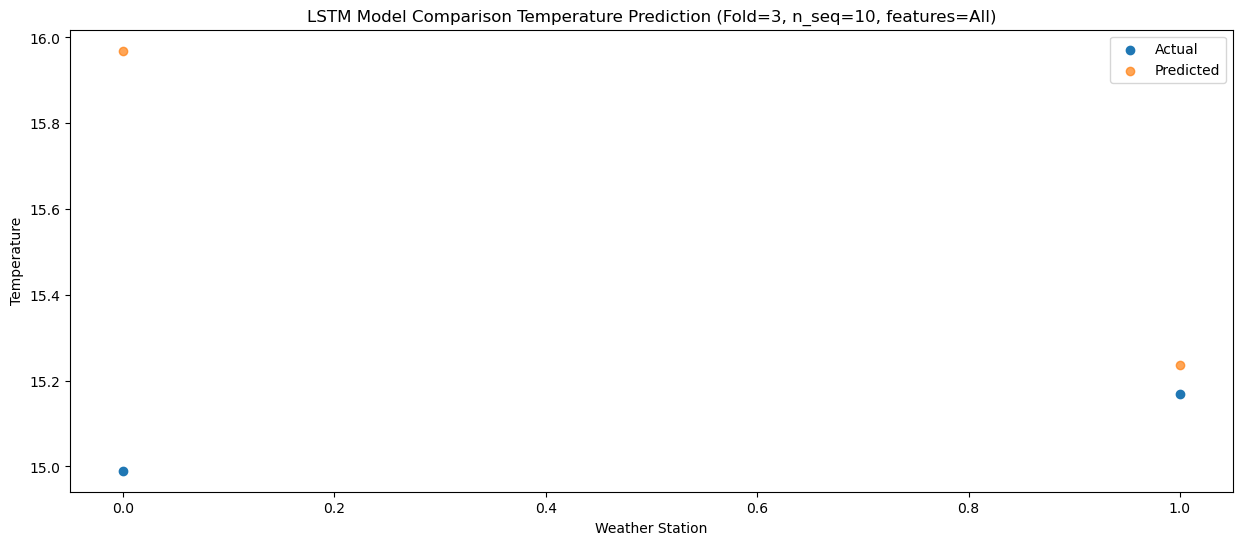

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.525260
1                1   15.05  15.792082


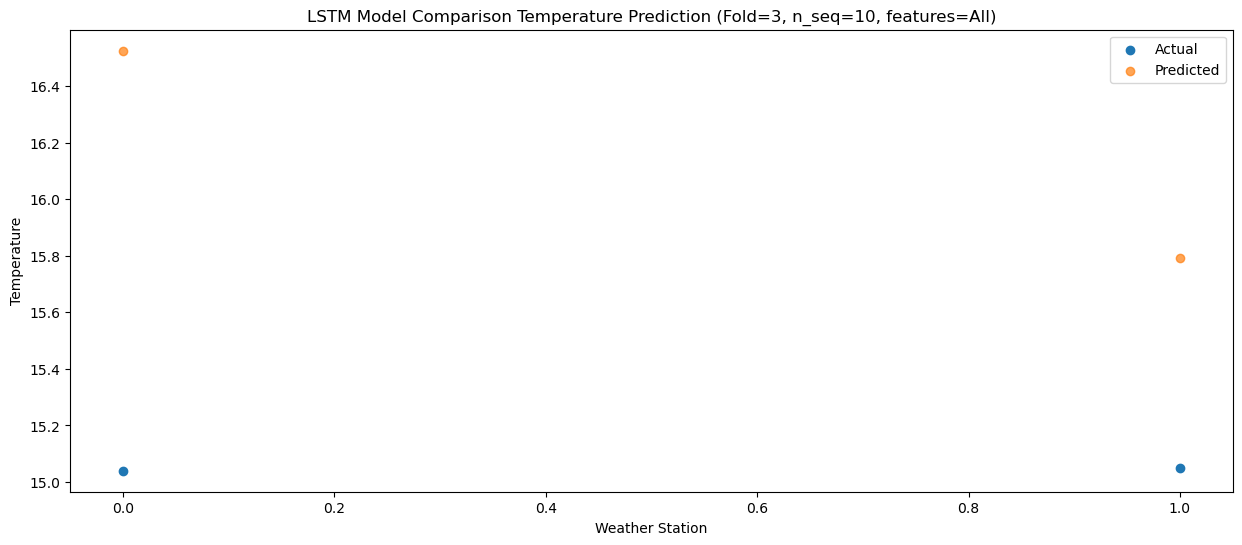

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  15.961198
1                1   14.85  15.228127


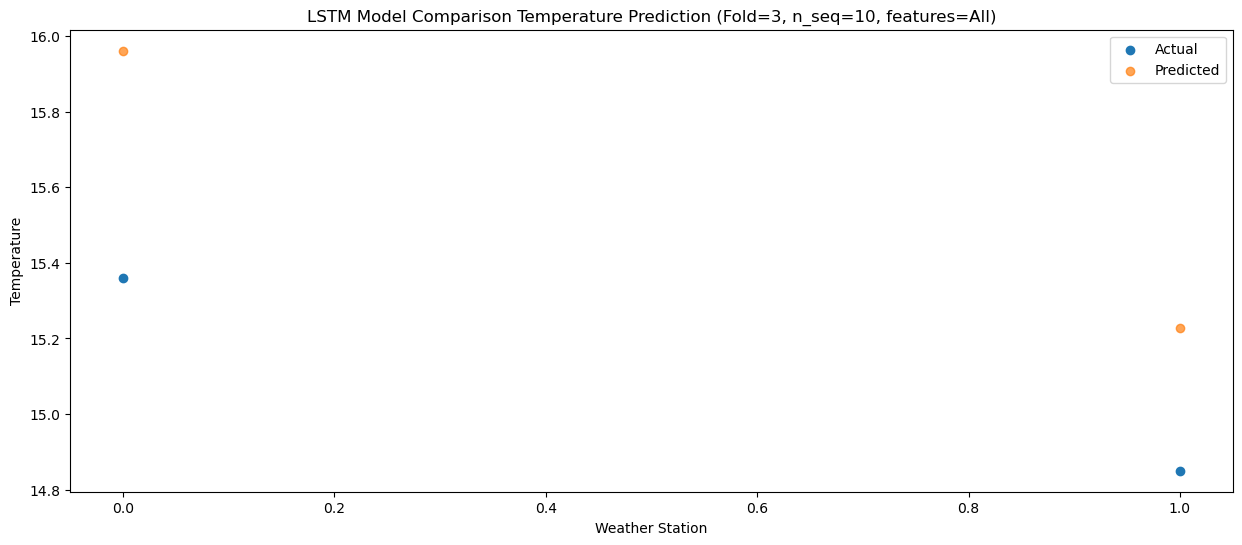

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  15.595361
1                1   14.55  14.860653


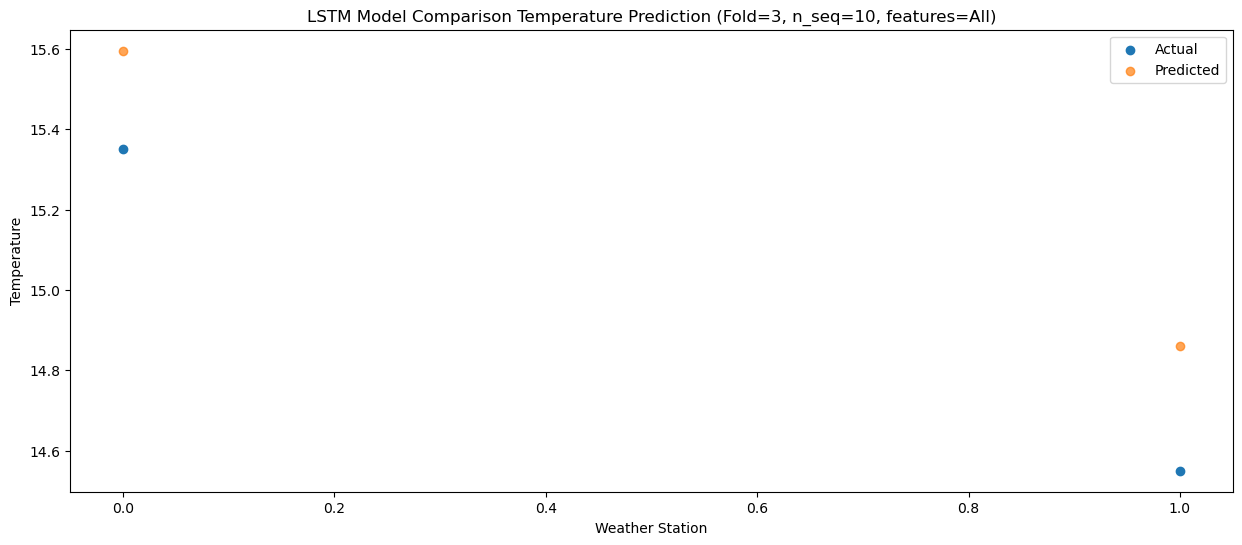

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  16.771296
1                1   15.57  16.036249


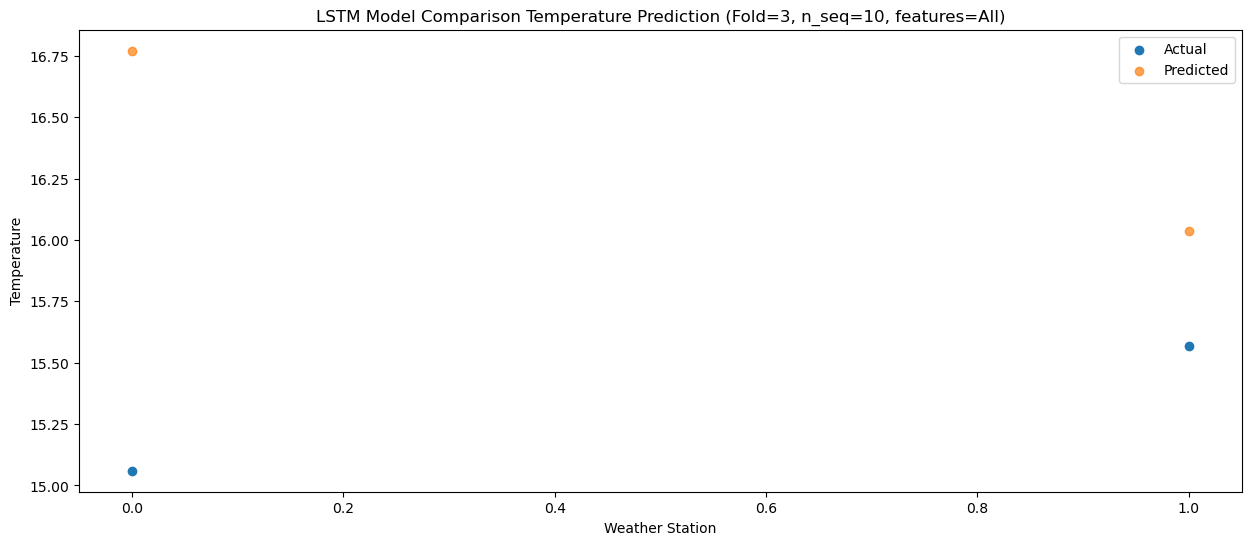

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[15.06759659 14.33638593]
 [16.19345967 15.46247074]
 [16.58382327 15.85281041]
 [17.00552798 16.2738415 ]
 [16.28668428 15.55444532]
 [15.96916349 15.23640615]
 [16.52526022 15.79208177]
 [15.9611981  15.22812748]
 [15.59536133 14.86065325]
 [16.77129576 16.03624925]]
Year at t+1:
t+1 SKRMSE: 1.208705
t+1 KRMSE: 1.208705
t+1 MAE: 1.204395
t+1 SKMAPE: 0.084218
t+1 R2_SCORE: 0.407291
t+1 KMAPE: 0.084218
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.017553
t+2 KRMSE: 1.017553
t+2 MAE: 0.937965
t+2 SKMAPE: 0.064513
t+2 R2_SCORE: -0.792613
t+2 KMAPE: 0.064513
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.924566
t+3 KRMSE: 0.924566
t+3 MAE: 0.833317
t+3 SKMAPE: 0.054224
t+3 R2_SCORE: -696.814171
t+3 KMAPE: 0.054224
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.418749
t+4 KRMSE: 1.418749
t+4 MAE: 1.374685
t+4 SKMAPE: 0.090032
t

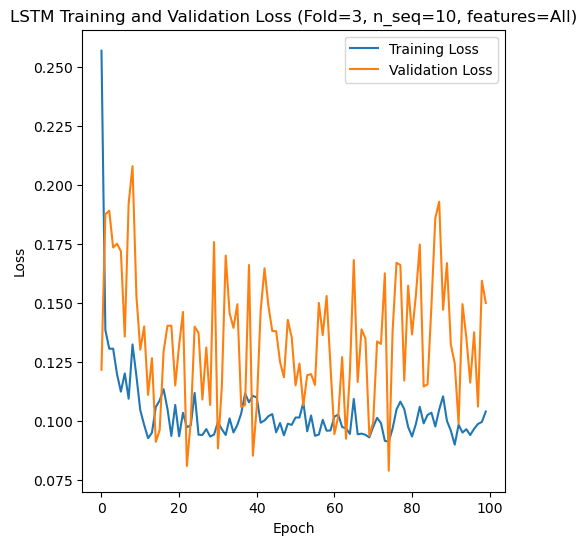

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 10s 83ms/step - loss: 0.3143 - accuracy: 0.2105 - mae: 0.2694 - rmse: 0.3143 - mape: 44.4628 - pearson: 0.2271 - val_loss: 0.1924 - val_accuracy: 0.0000e+00 - val_mae: 0.1564 - val_rmse: 0.1924 - val_mape: 24.8676 - val_pearson: 0.0558
Epoch 2/100
19/19 [==============================] - 0s 12ms/step - loss: 0.1518 - accuracy: 0.1579 - mae: 0.1249 - rmse: 0.1518 - mape: 20.1512 - pearson: 0.2500 - val_loss: 0.1432 - val_accuracy: 0.0000e+00 - val_mae: 0.1209 - val_rmse: 0.1432 - val_mape: 20.5295 - val_pearson: 0.3371
Epoch 3/100
19/19 [==============================] - 0s 9ms/step - loss: 0.1348 - ac

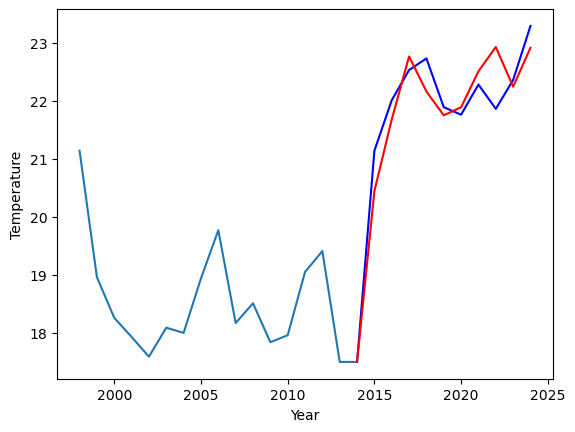

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.13		-0.50
14.58		13.44		-1.14
15.60		14.57		-1.03
15.53		13.94		-1.59
14.23		13.40		-0.83
13.53		13.53		-0.00
14.09		14.29		0.20
14.41		14.74		0.33
13.54		13.89		0.35
15.02		14.63		-0.39


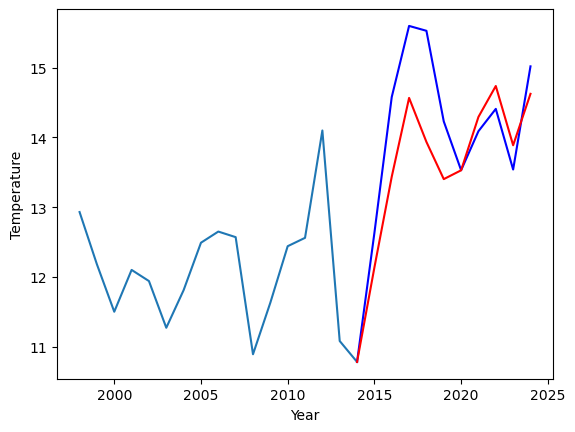

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.445488
1                1   12.63  12.134585


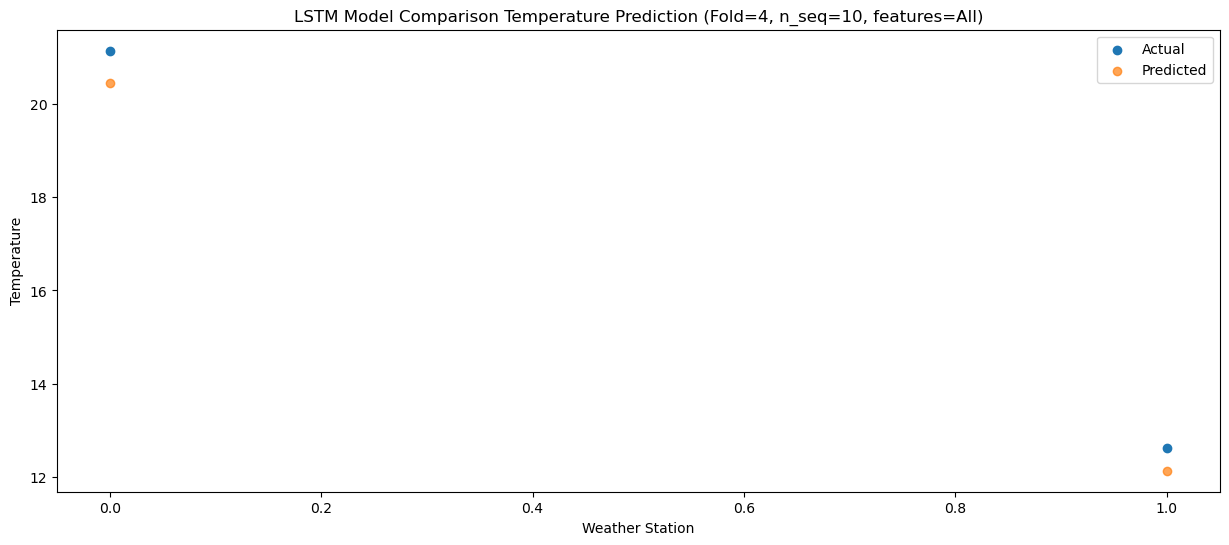

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.678197
1                1   14.58  13.436907


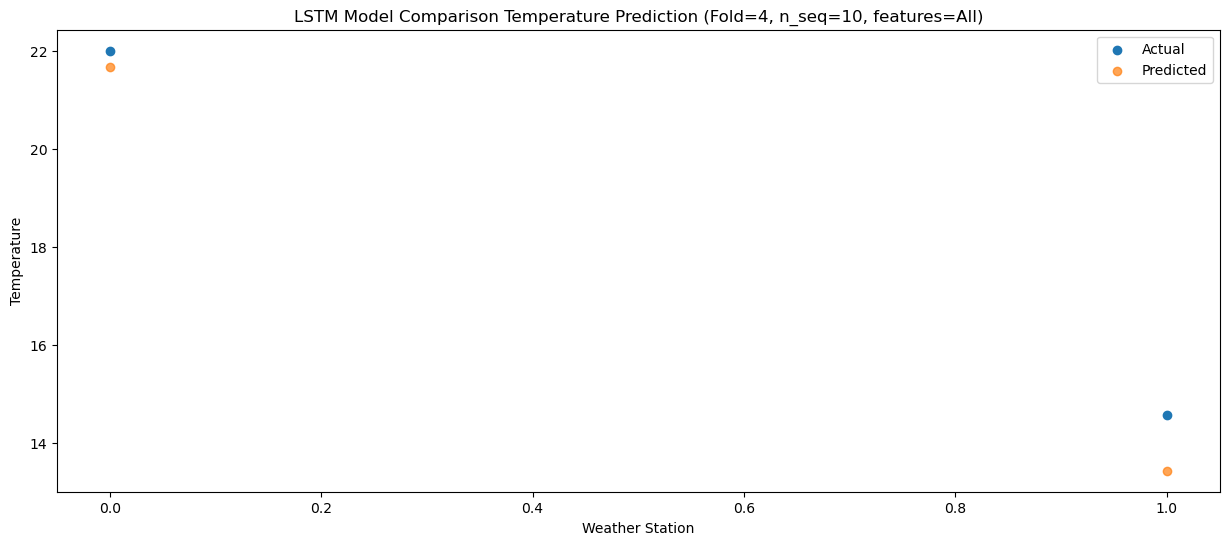

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.764310
1                1   15.60  14.567234


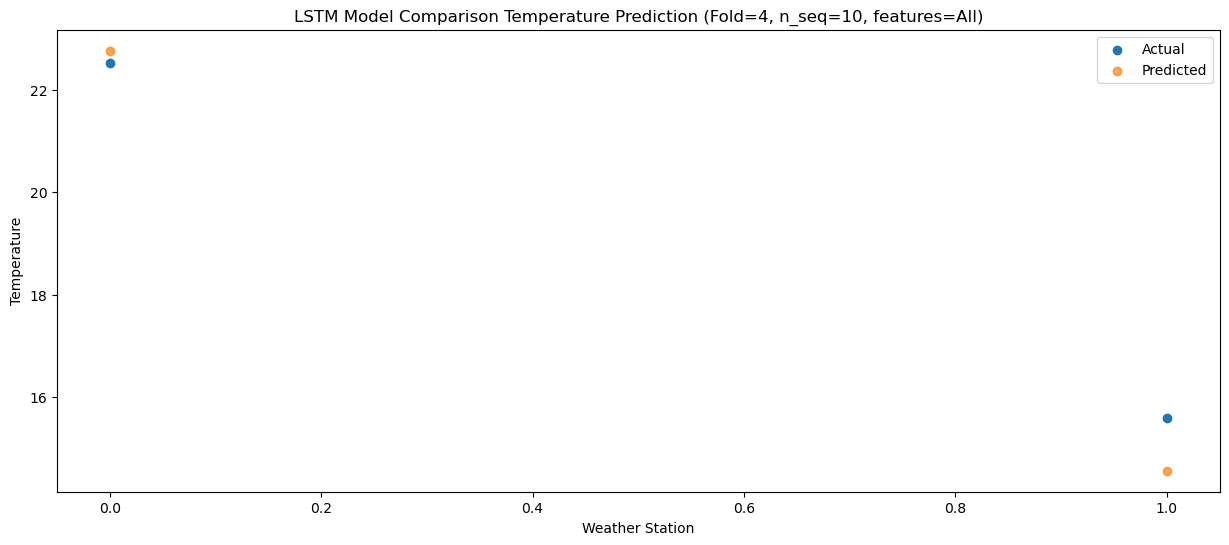

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  22.159934
1                1   15.53  13.936067


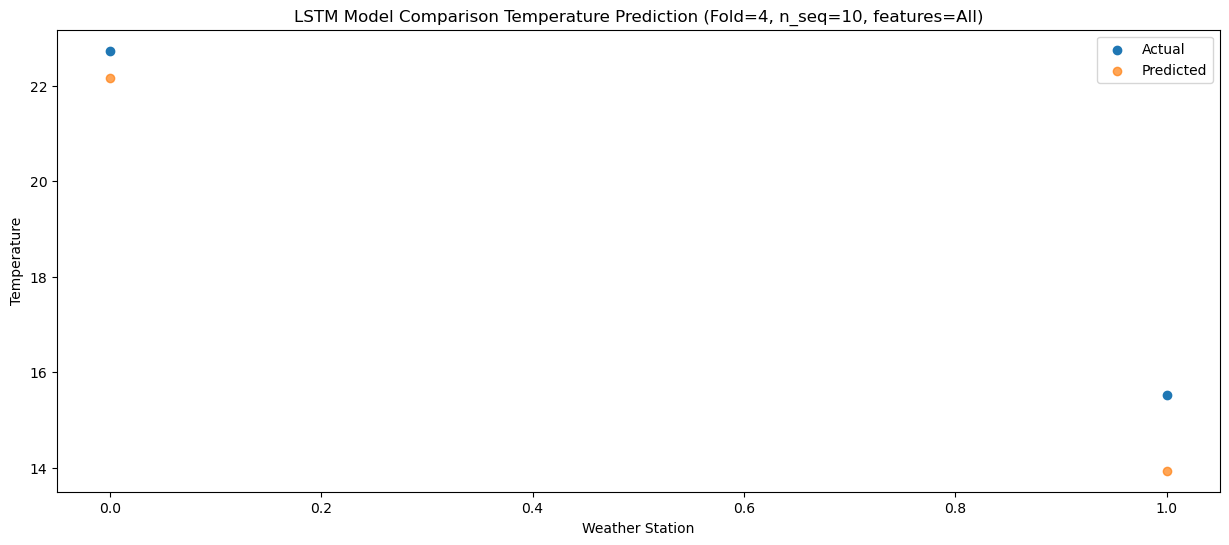

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.749589
1                1   14.23  13.402434


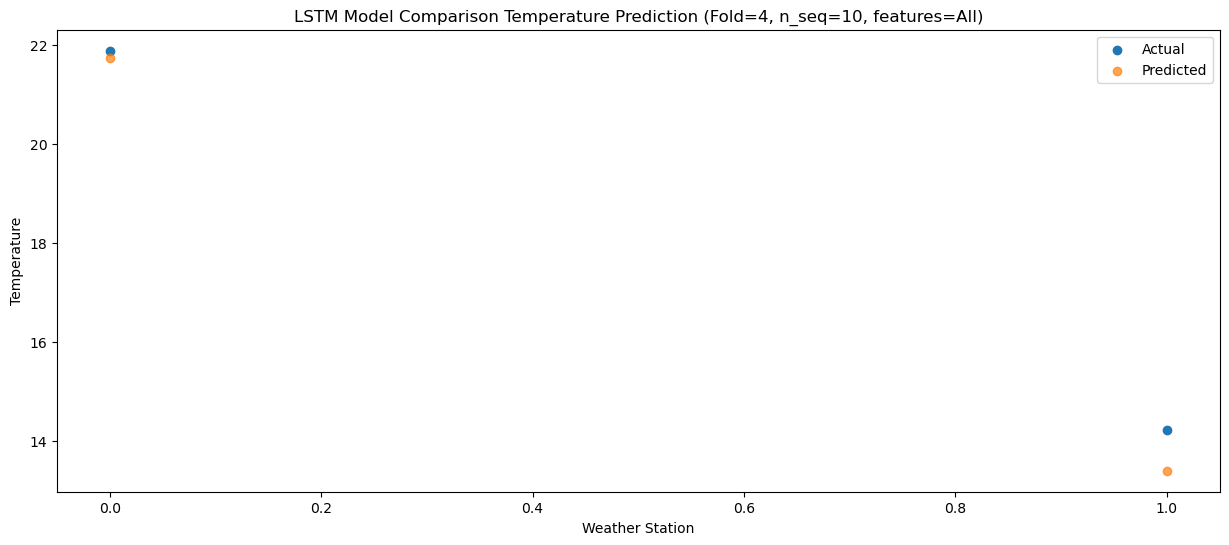

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.889175
1                1   13.53  13.528749


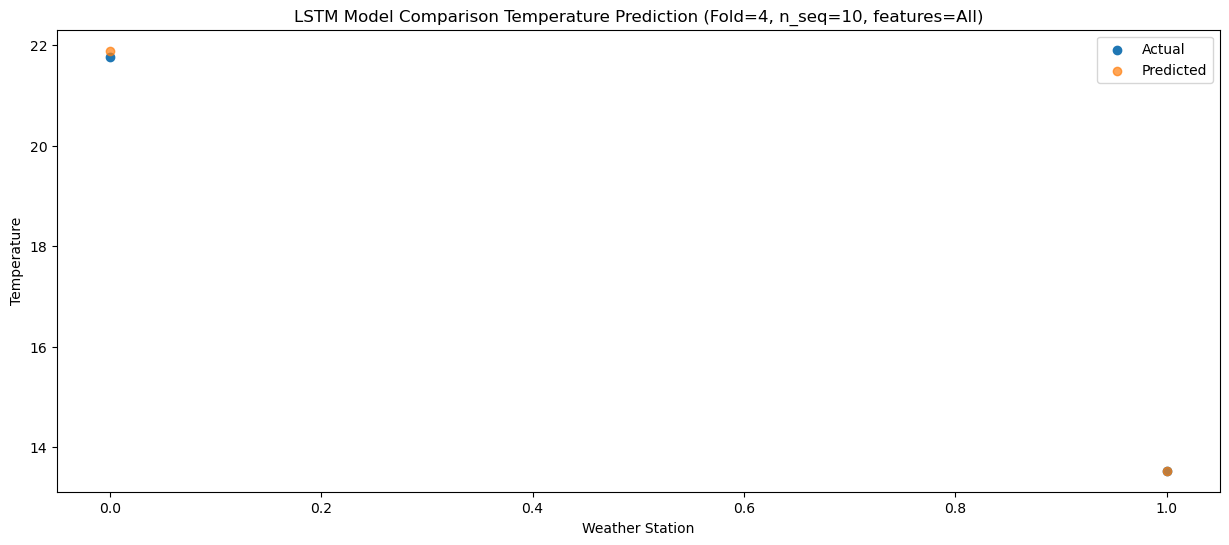

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  22.508375
1                1   14.09  14.294882


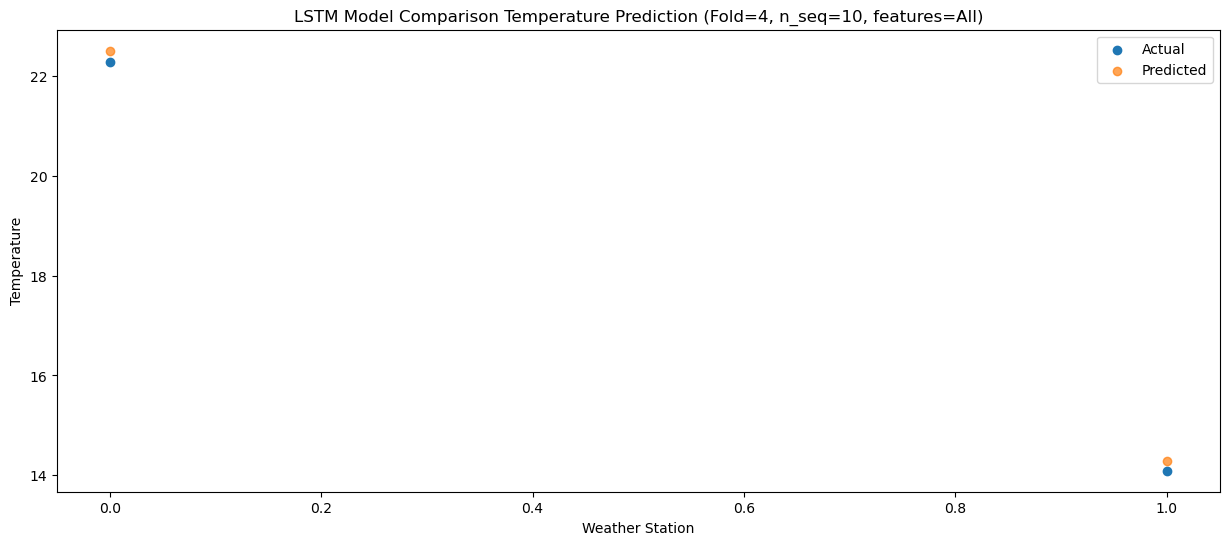

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  22.926666
1                1   14.41  14.738170


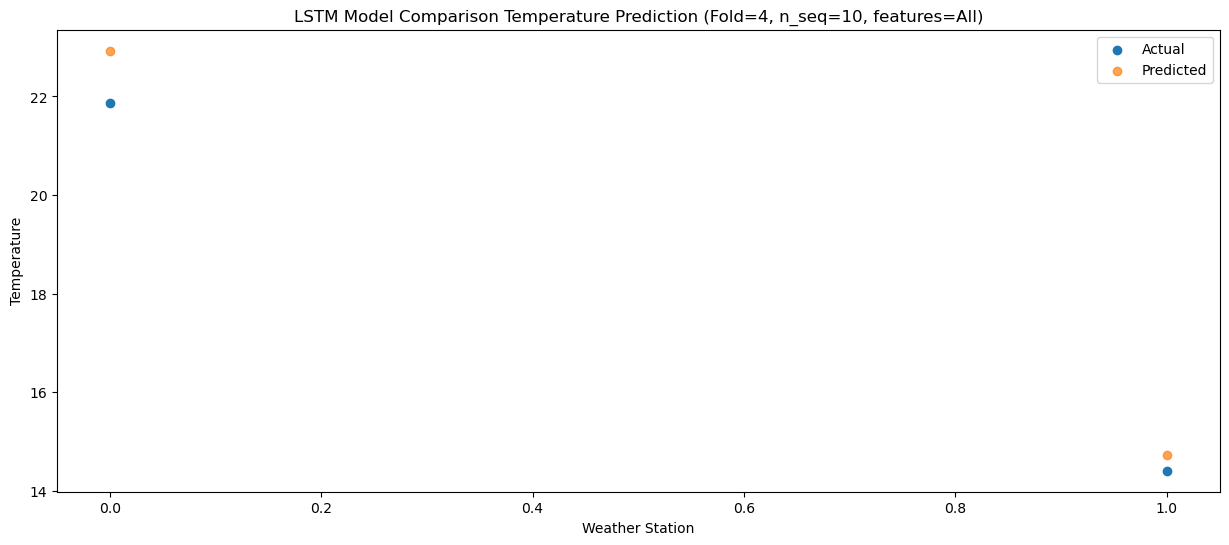

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  22.242874
1                1   13.54  13.888043


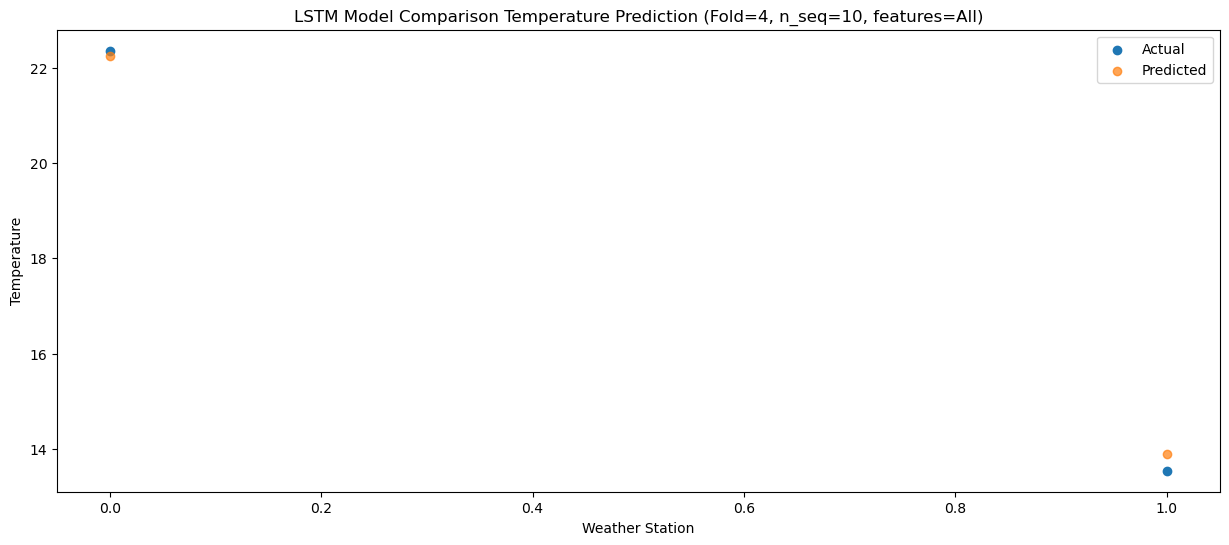

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  22.913519
1                1   15.02  14.625812


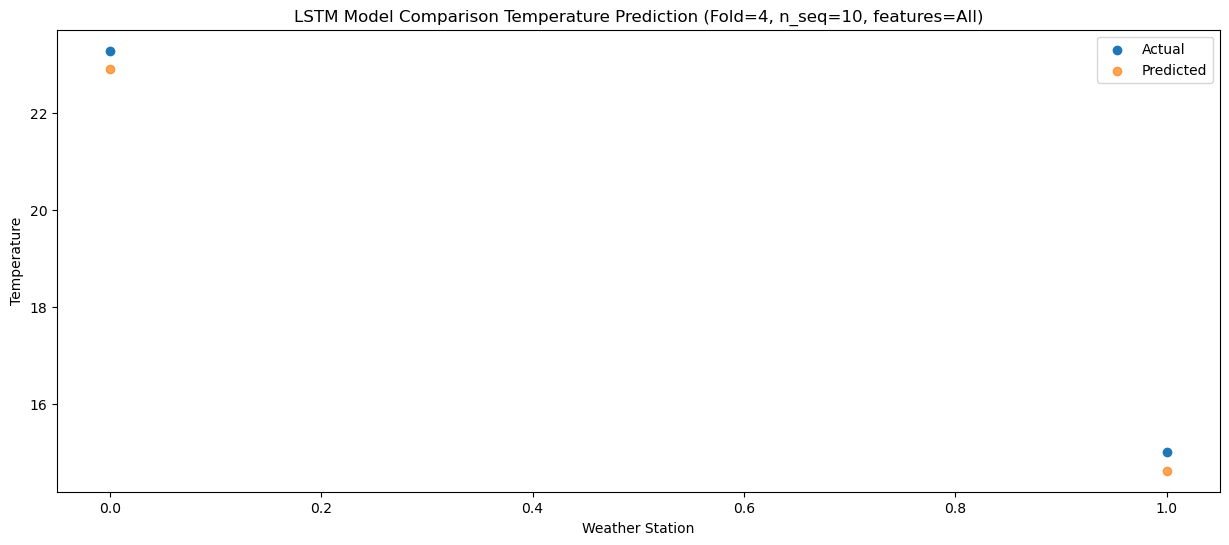

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.44548799 12.13458531]
 [21.67819656 13.43690711]
 [22.76430954 14.56723433]
 [22.15993412 13.93606722]
 [21.74958904 13.40243416]
 [21.88917473 13.52874947]
 [22.50837478 14.29488248]
 [22.92666608 14.73816998]
 [22.24287403 13.88804335]
 [22.91351867 14.62581236]]
Year at t+1:
t+1 SKRMSE: 0.603234
t+1 KRMSE: 0.603234
t+1 MAE: 0.594963
t+1 SKMAPE: 0.036039
t+1 R2_SCORE: 0.979901
t+1 KMAPE: 0.036039
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.841652
t+2 KRMSE: 0.841652
t+2 MAE: 0.737448
t+2 SKMAPE: 0.046738
t+2 R2_SCORE: 0.948673
t+2 KMAPE: 0.046738
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.748834
t+3 KRMSE: 0.748834
t+3 MAE: 0.633538
t+3 SKMAPE: 0.038301
t+3 R2_SCORE: 0.953295
t+3 KMAPE: 0.038301
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.196996
t+4 KRMSE: 1.196996
t+4 MAE: 1.081999
t+4 SKMAPE: 0.063858
t+4 R

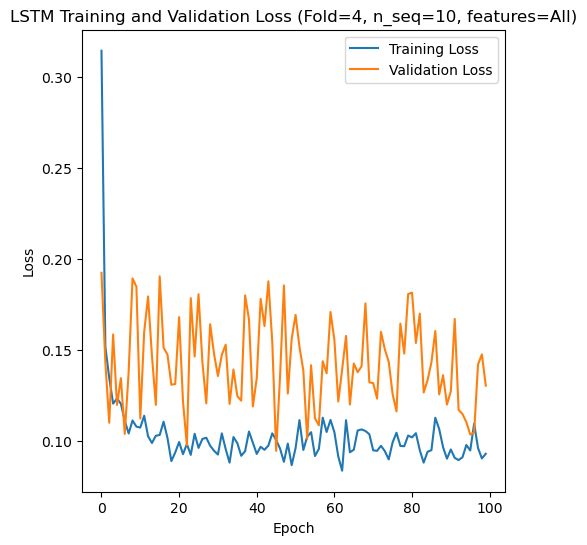

[[0.5917439952148464], [0.6982844203519355], [0.9514645350138369], [0.9936019609506193], [0.6566767494121319]]
[[array(0.591744)], [array(0.69828442)], [array(0.95146454)], [array(0.99360196)], [array(0.65667675)]]
[[0.4369963132739073], [0.6108418692797419], [0.7357606514692308], [0.870382465183735], [0.5129115287065504]]
[[0.022180252896402363], [0.030393652896592415], [0.04454778361330194], [0.05817029212943635], [0.030509260613331764]]
[[0.9168785986303549], [-1.1665769039982852], [0.7595538613492205], [-1.5319505271470653], [0.9730985897867231]]
[[array(0.02218025)], [array(0.03039365)], [array(0.04454778)], [array(0.05817029)], [array(0.03050926)]]
[[array(0.92842292)], [array(0.35486967)], [array(0.86005866)], [array(0.25350798)], [array(0.98072054)]]
[[[20.759463850557804, 22.00394779831171, 22.5695515909791, 21.96668488174677, 22.100832957923412, 21.281790275275707, 22.118207413852215, 22.27361196666956, 21.760620061457157, 22.493062380850315], [16.48814188659191, 17.737729780

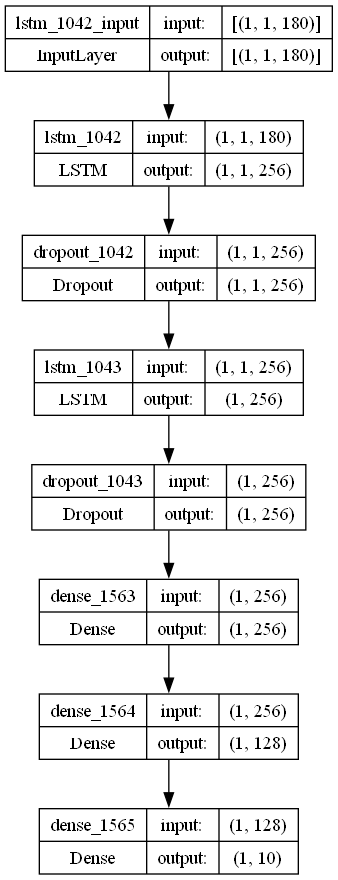

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.00438810205907512
    optimizer = Adam(learning_rate = lr)
    activation_function = 'sigmoid'
    lstm_units = 256
    dropout_rate = 0.2969030131988495

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=All)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(forecast_results)
print(actual_results)
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(np.mean(pearson_avg_list)))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_CV_S10.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)

In [14]:
print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

[[0.5917439952148464], [0.6982844203519355], [0.9514645350138369], [0.9936019609506193], [0.6566767494121319]]
[[array(0.591744)], [array(0.69828442)], [array(0.95146454)], [array(0.99360196)], [array(0.65667675)]]
[[0.4369963132739073], [0.6108418692797419], [0.7357606514692308], [0.870382465183735], [0.5129115287065504]]
[[0.022180252896402363], [0.030393652896592415], [0.04454778361330194], [0.05817029212943635], [0.030509260613331764]]
[[0.9168785986303549], [-1.1665769039982852], [0.7595538613492205], [-1.5319505271470653], [0.9730985897867231]]
[[array(0.02218025)], [array(0.03039365)], [array(0.04454778)], [array(0.05817029)], [array(0.03050926)]]
[[array(0.92842292)], [array(0.35486967)], [array(0.86005866)], [array(0.25350798)], [array(0.98072054)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 20.22